In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
df=pd.read_csv('./국민건강보험공단_건강검진정보_20211229.csv', encoding = 'cp949')

### 0.Training Data와 Test Data 분리

In [3]:
print('데이터 총 개수 :', df.shape)
print('가입자 일렬번호 총 개수(겹치지 않음 확인) :' ,df['가입자 일련번호'].nunique())

데이터 총 개수 : (1000000, 31)
가입자 일렬번호 총 개수(겹치지 않음 확인) : 1000000


In [4]:
data=df[df['가입자 일련번호']%10 !=5].copy()
data_test =df[df['가입자 일련번호']%10 ==5].copy()

In [5]:
target_sex = df[['성별코드']]
target_age = df[['연령대 코드(5세단위)']]

<AxesSubplot:ylabel='Count'>

<Figure size 1080x720 with 0 Axes>

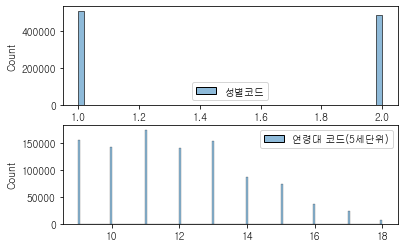

In [6]:
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(2,1)
sns.histplot(target_sex,ax=ax[0])
sns.histplot(target_age,ax=ax[1])

### 1. feature 하나씩 관찰하면서 성별, 나이대와 관련이 되는지 판별

각 feature 이상치,결측치 제거 후,  
성별, 연령대에 따른 그래프의 분포와 평균과 표준편차를 보고 판별 후 도움 된다고 생각하면 feature 기억

In [7]:
sex_ft =[]
age_ft=[]
sex_rank=pd.DataFrame(columns={'영향도'})

In [8]:
def data_about(data,feature):
    print(data[[feature]].info()),print()
    print(data[feature].describe()),print()
    print(data[feature].sort_values().tail(10)),print()
    num = data[[feature]].isnull().sum(0)[0]
    
    if num!=0:
        print('결측치 개수 :',num),print()
    print(data[feature].sort_values().head(10)),print()
    
#결측치 제거
def del_nan(data,feature):
    print('삭제한 결측치 개수 :',data[[feature]].isnull().sum(0))
    data.dropna(subset=[feature],inplace=True)
    data=data.reset_index()
    data.drop('index',axis=1,inplace=True)

In [9]:
#outlier 지우기
def remove_outlier(df,feature):
    df_removed = df.copy()
    if df_removed.dtypes[feature] == 'object':
        return df_removed
    quantiles =list(df_removed[feature].describe())
    Q1 = quantiles[4]
    Q2= quantiles[5]
    Q3 = quantiles[6]
    IQR = Q3 - Q1
    LeftBound=Q1 - 1.5 * IQR
    RightBound = Q3 + 1.5 * IQR
    df_removed.loc[(df_removed[feature]<LeftBound) | (df_removed[feature]>RightBound),feature] = np.nan
    #결측값을 가진 행 지우기
    df_removed=df_removed.dropna(subset=[feature])
    
    return df_removed


#나이와 얼마나 영향이 있는지 확인
#두 집단이 얼마나 분리됐냐에 대해 집단 간 평균 / 표준편차(평균) < 0.5 미만이면 분리를 제대로 못한다고 판단
# P(Z<0.25) = 0.1이므로 두 분포가 정규분포를 이룰 때 두 분포의 교점을 기준으로 판단하면 정확도 60%
def distribution_sex(df,feature,width=2):
    plt.figure(figsize=(10,5))
    sns.histplot(df,x=feature,hue='성별코드',multiple='dodge',palette='Set2',binwidth =width)
    plt.show()
    
    men = df[df['성별코드']==1][feature]
    women =df[df['성별코드']==2][feature]
    
    men_mean = men.mean()
    men_std = men.std()
    women_mean = women.mean()
    women_std = women.std()
    

    print('남자 평균:', men_mean)
    print('남자 표준편차:',men_std )
    print('여자 평균', women_mean)
    print('여자 표준편차:', women_std)
    
    
    # 영향도
    # 최대한 정규분포와 가깝게 만든 후 (평균의 차이 / 표준편차)를 영향도로 활용
    men = np.log1p(men)
    women = np.log1p(women)
    
    men_mean = men.mean()
    men_std = men.std()
    women_mean = women.mean()
    women_std = women.std()
    
    dif_mean=abs(men_mean-women_mean)
    std = (men_std+women_std)/2
    
    # 이 수치를 성별에 얼마나 영향을 끼치는 지 영향도로 활용
    print('평균차이/표준편차의평균',dif_mean/std)
    
    #나중에 영향도 사용하기 위해 데이터프레임에 저장.
    sex_rank.loc[feature]=[dif_mean/std]
    


def distribution_age(df,feature,width=2):
    sns.boxplot(x='연령대',y=feature,data=df)
    ages=df['연령대'].unique()
    ages.sort()
    
    for val in ages:
        age_df=df[df['연령대']==val]
        print(val,'대 평균:', age_df[feature].mean())
        print(val,'대 표준편차', age_df[feature].std())
        

#outlier들은 평균과 표준편차에 방해되므로 제거하고 분석
def distributions(dataframe,feature,width=2,remove=True):
    if remove:
        dataframe=remove_outlier(dataframe,feature)
    distribution_sex(dataframe,feature,width)
    distribution_age(dataframe,feature,width)

0. 기준년도와 공개일자는 모두 같은 값을 가지므로 삭제

In [10]:
data.drop(['기준년도','데이터 공개일자'],axis=1,inplace=True)
data_test.drop(['기준년도','데이터 공개일자'],axis=1,inplace=True)

1. 가입자 일련번호는 건강검진 순서를 나타냄  
성별 : 도움이 안될 듯   
나이대 : 가끔 어느 특정 대상에게 건강검진 무료 이벤트 같은 혜택을 주니까 어느 기간동안은 특정 연령대가 밀집되지 않을까? -> 특별한 차이 없음 feature 삭제

In [11]:
tmp=[]
for i in range(0,900):
    tmp_group = data['연령대 코드(5세단위)'].iloc[i*1000 :(i+1)*1000-1]
    tmp.append((str(i+1)+'번째그룹',tmp_group.mean(),tmp_group.std()))

group_time=pd.DataFrame(tmp,columns=['그룹','평균','표준편차'])
#표준편차가 제일 작은 시간 구간; 가장 나이대가 밀집되어 있다고 생각되는 지점
group_time[group_time['표준편차']==group_time.describe().loc['min']['표준편차']]

,그룹,평균,표준편차
499,500번째그룹,11.784785,2.035932


C:\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='연령대 코드(5세단위)'>

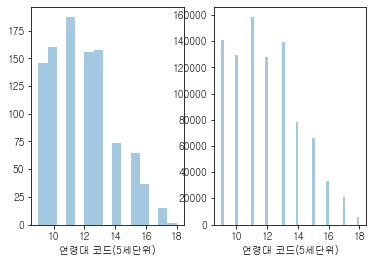

In [12]:
data_tmp1=data.iloc[499*1000:500*1000-1]
fig, ax = plt.subplots(1,2)
sns.distplot(data_tmp1['연령대 코드(5세단위)'],kde=False,ax=ax[0])
sns.distplot(data['연령대 코드(5세단위)'],kde=False,ax=ax[1])

가장 밀집되어 있다고 생각한 구간의 나이대 분포가 전체 구간의 나이대 분포랑 같음       -> 영향 크게 없음

In [13]:
data.drop(['가입자 일련번호'],axis=1,inplace=True)
data_test.drop(['가입자 일련번호'],axis=1,inplace=True)

+ 어차피 모델링에서 연령대를 10살 기준

In [14]:
data[['연령대 코드(5세단위)']]=data[['연령대 코드(5세단위)']].apply(lambda x : round((x-2)*5,-1))
data=data.rename(columns={'연령대 코드(5세단위)':'연령대'})

data_test[['연령대 코드(5세단위)']]=data_test[['연령대 코드(5세단위)']].apply(lambda x : round((x-2)*5,-1))
data_test=data_test.rename(columns={'연령대 코드(5세단위)':'연령대'})

2, 시도코드 -> 삭제

In [15]:
data.drop('시도코드',axis=1,inplace=True)
data_test.drop('시도코드',axis=1,inplace=True)

3.신장 -> 성별, 연령대 영향 끼침  
성별 : 성별 별로 확실히 차이가 남  
연령대 : 나이가 높아질수록 키의 분포가 작은쪽으로 이동, 성장기 환경이 예전과 달라져서 그런 듯

In [16]:
#결측치,이상치 없음
data_about(data,'신장(5Cm단위)')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   신장(5Cm단위)  900000 non-null  int64
dtypes: int64(1)
memory usage: 13.7 MB
None

count    900000.000000
mean        160.964450
std           9.198101
min         130.000000
25%         155.000000
50%         160.000000
75%         170.000000
max         195.000000
Name: 신장(5Cm단위), dtype: float64

46641     195
561805    195
944759    195
801697    195
517126    195
8831      195
609932    195
491153    195
170950    195
378050    195
Name: 신장(5Cm단위), dtype: int64

430625    130
660732    130
147712    130
217332    130
870306    130
454707    130
991760    130
105511    130
890213    130
46271     130
Name: 신장(5Cm단위), dtype: int64



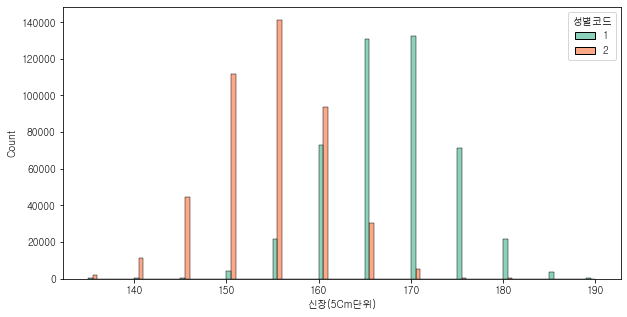

남자 평균: 167.45216117885647
남자 표준편차: 6.5096485859564455
여자 평균 154.21144721772802
여자 표준편차: 6.1978513624460465
평균차이/표준편차의평균 2.078642117629282
40 대 평균: 163.88437088101153
40 대 표준편차 8.703808548892061
50 대 평균: 160.66850010577534
50 대 표준편차 8.43027535173986
60 대 평균: 158.17627353871515
60 대 표준편차 8.50467746280219
70 대 평균: 154.99453535322868
70 대 표준편차 8.926023917750458
80 대 평균: 152.82061917870206
80 대 표준편차 9.27914651116172


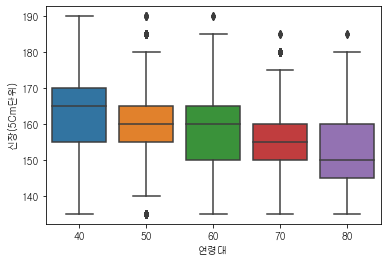

In [17]:
distributions(data,'신장(5Cm단위)',1)

In [18]:
age_ft.append('신장(5Cm단위)')

4. 체중 -> 성별, 연령대 모두 영향 끼침  
성별 : 신장과 마찬가지로 영향 끼침  
연령대 : 신장에서 차이가 나서 연령대에 영향 끼칠 듯 -> 실제로 갈수록 평균 체중이 줄어듦

In [19]:
#결측치,이상치 없음
data_about(data,'체중(5Kg 단위)')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   체중(5Kg 단위)  900000 non-null  int64
dtypes: int64(1)
memory usage: 13.7 MB
None

count    900000.000000
mean         63.064578
std          12.270655
min          30.000000
25%          55.000000
50%          60.000000
75%          70.000000
max         135.000000
Name: 체중(5Kg 단위), dtype: float64

590232    135
487376    135
709812    135
730285    135
197762    135
478987    135
923189    135
389458    135
382697    135
906611    135
Name: 체중(5Kg 단위), dtype: int64

511577    30
328958    30
472721    30
432976    30
925986    30
603192    30
508165    30
228235    30
825093    30
484628    30
Name: 체중(5Kg 단위), dtype: int64



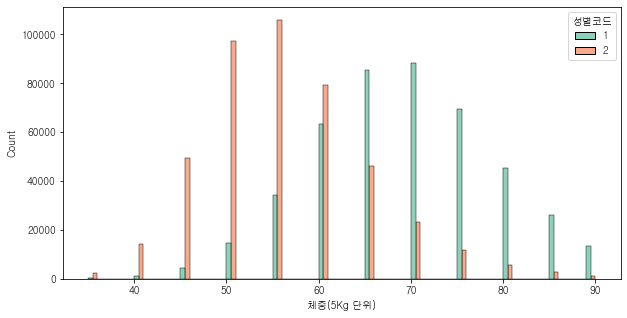

남자 평균: 68.76861844777633
남자 표준편차: 9.785896747654443
여자 평균 56.036105426752286
여자 표준편차: 8.909095969216244
평균차이/표준편차의평균 1.367866745113625
40 대 평균: 64.4604461889232
40 대 표준편차 11.923608936553018
50 대 평균: 62.33020448152713
50 대 표준편차 10.723190459781557
60 대 평균: 60.7553823245417
60 대 표준편차 10.147625191231121
70 대 평균: 58.055597774873085
70 대 표준편차 9.891958471526879
80 대 평균: 55.031960361587046
80 대 표준편차 10.219058408586031


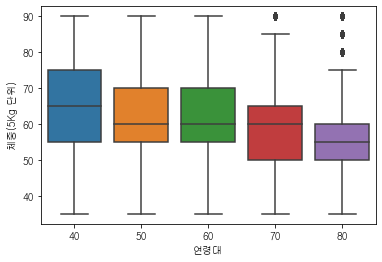

In [20]:
distributions(data,'체중(5Kg 단위)',1)

In [21]:
age_ft.append('체중(5Kg 단위)')

5. 허리둘레 -> 성별
성별 : 예상대로 차이 큼  
연령대 : 예상과는 다르게 40대 50대가 60대 이상보다 낮음

-> 골반둘레인 줄 알았는데 뱃살까지 재는 사이즈라 나이 들면 커질수도 있을 듯, 근데 연령대별로는 별로 움직이지 않아서 쓰지 않음

In [22]:
#데이터 확인 그리고 결측치 및 이상치 점검
data_about(data,'허리둘레')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   허리둘레    899902 non-null  float64
dtypes: float64(1)
memory usage: 13.7 MB
None

count    899902.000000
mean         82.358578
std           9.632363
min           5.800000
25%          76.000000
50%          82.000000
75%          89.000000
max         999.000000
Name: 허리둘레, dtype: float64

884619   NaN
885098   NaN
893770   NaN
902828   NaN
906225   NaN
906533   NaN
937762   NaN
946711   NaN
955240   NaN
990120   NaN
Name: 허리둘레, dtype: float64

결측치 개수 : 98

321346     5.8
900467     8.2
120539     8.7
854340    35.0
310919    36.0
879765    39.0
282296    41.0
142277    42.0
961772    44.0
327182    48.0
Name: 허리둘레, dtype: float64



In [23]:
del_nan(data,'허리둘레')

삭제한 결측치 개수 : 허리둘레    98
dtype: int64


In [24]:
#이상치 점검
print(data['허리둘레'].sort_values().tail())
data['허리둘레'].sort_values().head()

87896     142.0
866336    144.0
993530    146.0
590866    680.0
484092    999.0
Name: 허리둘레, dtype: float64


321346     5.8
900467     8.2
120539     8.7
854340    35.0
310919    36.0
Name: 허리둘레, dtype: float64

In [25]:
data[(data['허리둘레']<10)|(data['허리둘레']>200.0)]=np.nan
del_nan(data,'허리둘레')

삭제한 결측치 개수 : 허리둘레    5
dtype: int64


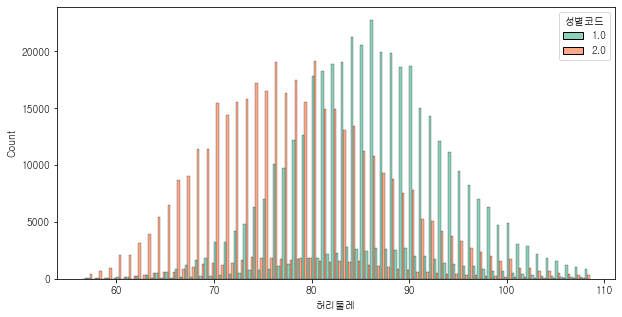

남자 평균: 85.93093298672555
남자 표준편차: 7.875175272507906
여자 평균 78.2961126299023
여자 표준편차: 8.93876520225701
평균차이/표준편차의평균 0.9252265217697726
40.0 대 평균: 81.28803107613231
40.0 대 표준편차 9.710191586464928
50.0 대 평균: 81.87867045606633
50.0 대 표준편차 8.797000149762006
60.0 대 평균: 83.25195823008849
60.0 대 표준편차 8.581348435873545
70.0 대 평균: 84.5425485829342
70.0 대 표준편차 8.641528030175094
80.0 대 평균: 83.81982328953329
80.0 대 표준편차 9.131497397166477


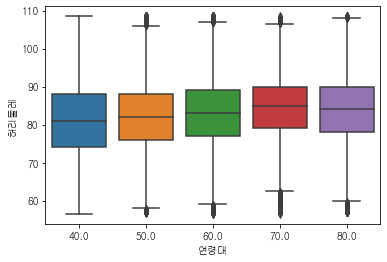

In [26]:
distributions(data,'허리둘레',0.5)

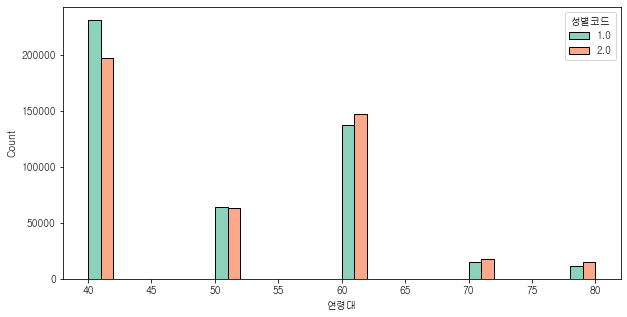

남자 평균: 49.37009313256158
남자 표준편차: 10.752314166145002
여자 평균 50.6881320443206
여자 표준편차: 11.17119447023447
평균차이/표준편차의평균 0.12049542883018109


In [27]:
#나이들수록 여자가 더 많음
distribution_sex(data,'연령대')

6. 시력(좌), 시력(우), 실명은 9.9  
성별 : 별로 관계 없을 듯 -> 생각보다 영향력 있음(고등학교 때부터 차이난다고 함)  
연령대 : 연령 높을 수록 시력이 줄어들 거 같음  
-> 실제로 연령대가 올라갈 수록 실명할 비율이 늘어나지만 수가 1%미만이므로 따로 feature을 만들지는 않고, 어차피 연령대와 시력은 반비례하니 -0.1정도로 대체

In [28]:
# 결측치 제거 및 실명 여부 확인
data_about(data,'시력(좌)')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899897 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   시력(좌)   899711 non-null  float64
dtypes: float64(1)
memory usage: 13.7 MB
None

count    899711.000000
mean          0.932977
std           0.637155
min           0.100000
25%           0.700000
50%           0.900000
75%           1.200000
max           9.900000
Name: 시력(좌), dtype: float64

930402   NaN
953385   NaN
963400   NaN
972523   NaN
973100   NaN
976467   NaN
988946   NaN
989070   NaN
989143   NaN
999393   NaN
Name: 시력(좌), dtype: float64

결측치 개수 : 186

475020    0.1
991500    0.1
30282     0.1
783716    0.1
823366    0.1
479661    0.1
951552    0.1
628828    0.1
171592    0.1
951571    0.1
Name: 시력(좌), dtype: float64



In [29]:
data_about(data,'시력(우)')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899897 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   시력(우)   899718 non-null  float64
dtypes: float64(1)
memory usage: 13.7 MB
None

count    899718.000000
mean          0.934732
std           0.642539
min           0.100000
25%           0.700000
50%           0.900000
75%           1.200000
max           9.900000
Name: 시력(우), dtype: float64

930402   NaN
961507   NaN
963400   NaN
972523   NaN
973100   NaN
976467   NaN
988946   NaN
989070   NaN
989143   NaN
999393   NaN
Name: 시력(우), dtype: float64

결측치 개수 : 179

596752    0.1
391186    0.1
873221    0.1
391280    0.1
123430    0.1
391321    0.1
228323    0.1
632202    0.1
391381    0.1
632078    0.1
Name: 시력(우), dtype: float64



In [30]:
del_nan(data,'시력(좌)')
del_nan(data,'시력(우)')

삭제한 결측치 개수 : 시력(좌)    186
dtype: int64
삭제한 결측치 개수 : 시력(우)    7
dtype: int64


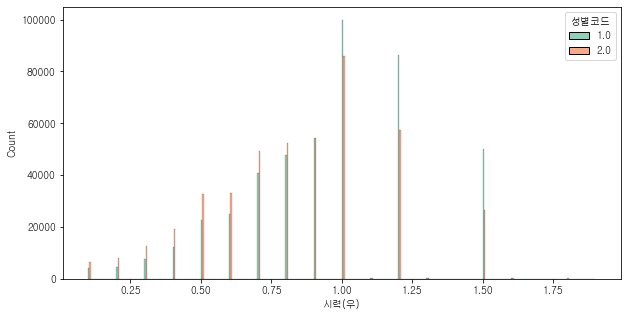

남자 평균: 0.9430609690645454
남자 표준편차: 0.3125336082558288
여자 평균 0.8455663611638058
여자 표준편차: 0.3109094811006514
평균차이/표준편차의평균 0.3072445753692666
40.0 대 평균: 0.9961483826740827
40.0 대 표준편차 0.30720641844003976
50.0 대 평균: 0.9131824774938118
50.0 대 표준편차 0.28719829197877217
60.0 대 평균: 0.7936326666643029
60.0 대 표준편차 0.2799684161200769
70.0 대 평균: 0.6487664927891991
70.0 대 표준편차 0.2685200605010179
80.0 대 평균: 0.5736641950772053
80.0 대 표준편차 0.267767751256286


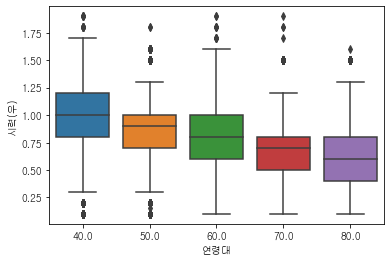

In [31]:
distributions(data,'시력(우)',0.01)

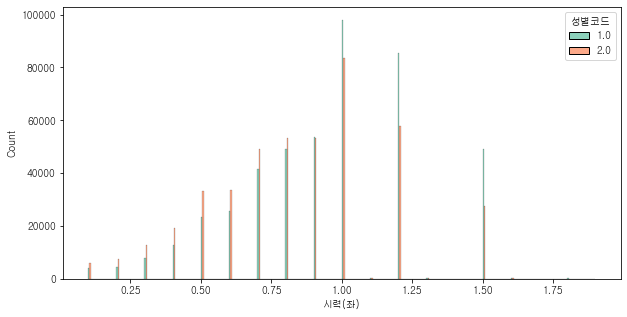

남자 평균: 0.9387499944960832
남자 표준편차: 0.3133735881398187
여자 평균 0.8461543652563795
여자 표준편차: 0.31218251117137097
평균차이/표준편차의평균 0.2913034536163353
40.0 대 평균: 0.9956025570534889
40.0 대 표준편차 0.3071963491990689
50.0 대 평균: 0.9119565217391304
50.0 대 표준편차 0.2888517759790953
60.0 대 평균: 0.7908816491483063
60.0 대 표준편차 0.2801776587732552
70.0 대 평균: 0.6421643052524817
70.0 대 표준편차 0.262940521603106
80.0 대 평균: 0.5642519083969465
80.0 대 표준편차 0.26434336151923415


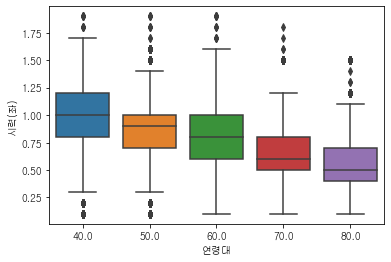

In [32]:
distributions(data,'시력(좌)',0.01)

In [33]:
#실명한 사람 수 및 실명한 비율 -> 사람 수가 적지만 연령대별로 비율 차이가 남. -> 지우지 말고 대체
print(data[(data['시력(좌)']==9.9) | (data['시력(우)']==9.9)].shape)
data[(data['시력(좌)']==9.9) | (data['시력(우)']==9.9)].groupby(data['연령대']).count()['연령대']/data.groupby(data['연령대']).count()['성별코드']

(6212, 27)


연령대
40.0    0.002828
50.0    0.005078
60.0    0.009581
70.0    0.023405
80.0    0.032244
dtype: float64

In [34]:
# 실명을 -0.1로 대체
data.replace({'시력(좌)':9.9,'시력(우)':9.9},-0.1,inplace=True)

In [35]:
#성별과 연령대에 유사한 경향성을 가지므로 그냥 시력(우)+시력(좌) 하나로 통합
print(data['시력(우)'].corr(data['시력(좌)']))
data['시력']=data['시력(우)']+data['시력(좌)']
data.drop(columns=['시력(우)','시력(좌)'],axis=1,inplace=True)

data_test['시력']=data_test['시력(우)']+data_test['시력(좌)']
data_test.drop(columns=['시력(우)','시력(좌)'],axis=1,inplace=True)

0.682277932523912


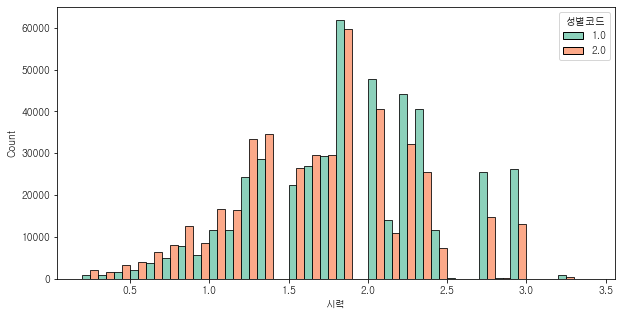

남자 평균: 1.8756881509758876
남자 표준편차: 0.5785294018112785
여자 평균 1.6879382610641092
여자 표준편차: 0.5787447324535467
평균차이/표준편차의평균 0.3184060174119105
40.0 대 평균: 1.9893218863464246
40.0 대 표준편차 0.5653531402420979
50.0 대 평균: 1.8223390860227746
50.0 대 표준편차 0.5247625886089522
60.0 대 평균: 1.5784593566435545
60.0 대 표준편차 0.5076289020115338
70.0 대 평균: 1.2780531620132145
70.0 대 표준편차 0.47793467681316365
80.0 대 평균: 1.1244664345720126
80.0 대 표준편차 0.4814144142905919


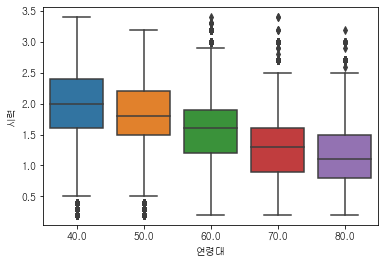

In [36]:
distributions(data,'시력',0.1)

In [37]:
age_ft.append('시력')

7.청력(좌),청력(우)  
성별 -> 영향 x  
연령대 : 연령대 별로 질환의심 비율이 올라가긴하지만 전체의 5%정도밖에 안되는 숫자라 그냥 삭제

In [38]:
data[(data['청력(좌)']==2) | (data['청력(우)']==2)].shape + data[(data['청력(좌)']==3) | (data['청력(우)']==3)].shape

(54049, 26, 2192, 26)

In [39]:
data.drop(columns=['청력(좌)','청력(우)'],axis=1,inplace=True)
data_test.drop(columns=['청력(좌)','청력(우)'],axis=1,inplace=True)

8. 수축기 혈압  
성별 : 영향 별로 없음  
연령대 : 연령대와 함께 증가하는 모습을 보임

In [40]:
data_about(data,'수축기 혈압')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899704 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   수축기 혈압  892903 non-null  float64
dtypes: float64(1)
memory usage: 46.0 MB
None

count    892903.000000
mean        124.832128
std          14.752245
min          64.000000
25%         115.000000
50%         124.000000
75%         134.000000
max         260.000000
Name: 수축기 혈압, dtype: float64

998469   NaN
998986   NaN
998999   NaN
999032   NaN
999169   NaN
999259   NaN
999358   NaN
999371   NaN
999416   NaN
999870   NaN
Name: 수축기 혈압, dtype: float64

결측치 개수 : 6801

849757    64.0
100183    65.0
977376    66.0
777665    69.0
342293    70.0
652238    70.0
639415    70.0
515179    70.0
990400    70.0
753676    70.0
Name: 수축기 혈압, dtype: float64



In [41]:
del_nan(data,'수축기 혈압')

삭제한 결측치 개수 : 수축기 혈압    6801
dtype: int64


In [42]:
data_about(data, '수축기 혈압')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892903 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   수축기 혈압  892903 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    892903.000000
mean        124.832128
std          14.752245
min          64.000000
25%         115.000000
50%         124.000000
75%         134.000000
max         260.000000
Name: 수축기 혈압, dtype: float64

245827    240.0
747505    240.0
958625    240.0
825985    241.0
389458    251.0
511813    253.0
183326    257.0
31555     257.0
12681     260.0
909045    260.0
Name: 수축기 혈압, dtype: float64

849757    64.0
100183    65.0
977376    66.0
777665    69.0
342293    70.0
652238    70.0
639415    70.0
515179    70.0
990400    70.0
753676    70.0
Name: 수축기 혈압, dtype: float64



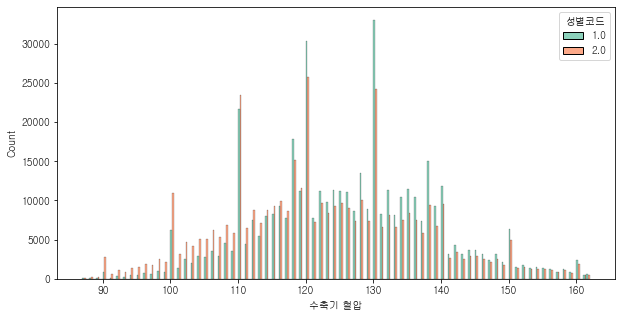

남자 평균: 125.95856232382506
남자 표준편차: 12.98742769781988
여자 평균 122.50786833680762
여자 표준편차: 14.299869364990178
평균차이/표준편차의평균 0.2647838486539537
40.0 대 평균: 121.61718933880641
40.0 대 표준편차 13.216847470995347
50.0 대 평균: 124.10833722874098
50.0 대 표준편차 13.367033079199661
60.0 대 평균: 127.15161936997465
60.0 대 표준편차 13.652491904942377
70.0 대 평균: 130.85393332023318
70.0 대 표준편차 13.857532145042773
80.0 대 평균: 130.80615588833118
80.0 대 표준편차 14.458440782149216


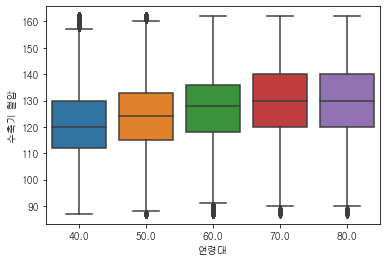

In [43]:
distributions(data,'수축기 혈압',0.5)

In [44]:
age_ft.append('수축기 혈압')

이완기 혈압  
성별 : 성별은 영향을 끼치는 것으로 보임.  
연령대 : 수축기 혈압과는 다르게 뚜렷한 차이가 보이진 않음

In [45]:
data_about(data,'이완기 혈압')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892903 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   이완기 혈압  892901 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    892901.000000
mean         76.814639
std           9.989185
min          30.000000
25%          70.000000
50%          77.000000
75%          83.000000
max         190.000000
Name: 이완기 혈압, dtype: float64

606902    150.0
220161    153.0
126148    158.0
378428    163.0
825985    163.0
832661    170.0
856615    178.0
747505    190.0
379276      NaN
760740      NaN
Name: 이완기 혈압, dtype: float64

결측치 개수 : 2

520351    30.0
948558    31.0
213627    31.0
62278     32.0
784722    32.0
456811    32.0
221596    33.0
851956    33.0
985973    34.0
599940    35.0
Name: 이완기 혈압, dtype: float64



In [46]:
del_nan(data,'이완기 혈압')

삭제한 결측치 개수 : 이완기 혈압    2
dtype: int64


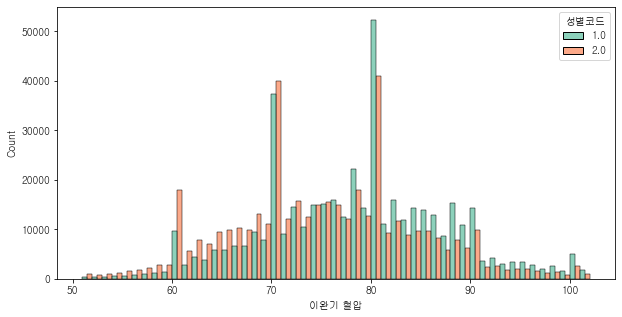

남자 평균: 78.14636176020238
남자 표준편차: 9.159835876614167
여자 평균 74.85652792394787
여자 표준편차: 9.415329813735156
평균차이/표준편차의평균 0.35772901210616936
40.0 대 평균: 76.58819755646618
40.0 대 표준편차 9.591919147120818
50.0 대 평균: 77.14753864785924
50.0 대 표준편차 9.282347665201897
60.0 대 평균: 76.4683177650801
60.0 대 표준편차 9.187960847543742
70.0 대 평균: 75.24976064339057
70.0 대 표준편차 9.458864799492732
80.0 대 평균: 74.90901806818637
80.0 대 표준편차 9.68421755811251


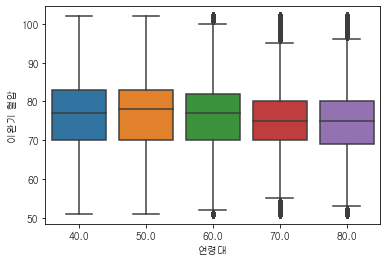

In [47]:
distributions(data,'이완기 혈압',1)

9.식전혈당 (실제로 혈당이 500넘을수도 있음)  
변수에 넣기 애매함

In [48]:
data_about(data,'식전혈당(공복혈당)')
del_nan(data,'식전혈당(공복혈당)')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892901 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   식전혈당(공복혈당)  892819 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    892819.000000
mean        104.259458
std          25.450445
min          24.000000
25%          91.000000
50%          99.000000
75%         109.000000
max         950.000000
Name: 식전혈당(공복혈당), dtype: float64

816126   NaN
819436   NaN
903193   NaN
923797   NaN
926840   NaN
935529   NaN
956672   NaN
956963   NaN
970207   NaN
970766   NaN
Name: 식전혈당(공복혈당), dtype: float64

결측치 개수 : 82

978380    24.0
23083     25.0
900723    29.0
237733    35.0
16171     35.0
902702    40.0
718942    40.0
542597    40.0
636590    41.0
94978     42.0
Name: 식전혈당(공복혈당), dtype: float64

삭제한 결측치 개수 : 식전혈당(공복혈당)    82
dtype: int64


In [49]:
data[data['식전혈당(공복혈당)']>300]

,성별코드,연령대,신장(5Cm단위),체중(5Kg 단위),허리둘레,수축기 혈압,이완기 혈압,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석,시력
79,2.0,40.0,155.0,55.0,86.0,139.0,88.0,367.0,NaN,NaN,...,0.7,21.0,23.0,33.0,1.0,1.0,0.0,NaN,NaN,1.9
2295,1.0,40.0,170.0,65.0,81.0,132.0,78.0,303.0,NaN,NaN,...,1.0,25.0,37.0,192.0,1.0,1.0,1.0,0.0,1.0,2.0
2472,1.0,40.0,165.0,90.0,91.0,124.0,89.0,317.0,NaN,NaN,...,0.8,42.0,96.0,119.0,2.0,1.0,1.0,0.0,1.0,1.7
2629,1.0,50.0,165.0,75.0,93.0,110.0,70.0,321.0,NaN,NaN,...,1.1,22.0,30.0,38.0,3.0,1.0,1.0,0.0,1.0,2.5
2791,1.0,40.0,165.0,65.0,86.2,144.0,82.0,473.0,95.0,77.0,...,1.3,105.0,35.0,143.0,3.0,1.0,0.0,NaN,NaN,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994131,2.0,80.0,140.0,45.0,84.0,128.0,70.0,406.0,249.0,132.0,...,1.6,24.0,19.0,26.0,1.0,0.0,0.0,NaN,NaN,0.8
995173,2.0,60.0,150.0,55.0,79.0,141.0,70.0,443.0,207.0,137.0,...,0.7,32.0,20.0,22.0,1.0,0.0,0.0,NaN,NaN,0.9
995547,1.0,60.0,155.0,60.0,84.0,120.0,70.0,309.0,NaN,NaN,...,0.6,24.0,27.0,30.0,2.0,0.0,0.0,NaN,NaN,1.4
997479,1.0,40.0,165.0,50.0,70.0,129.0,71.0,365.0,151.0,69.0,...,1.0,58.0,53.0,20.0,2.0,1.0,1.0,0.0,1.0,1.2


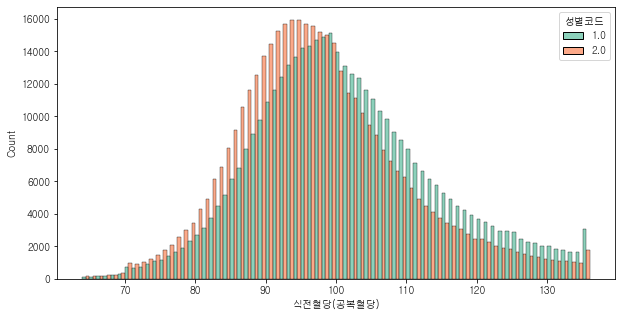

남자 평균: 101.0053479407783
남자 표준편차: 12.847421169927465
여자 평균 97.40216641169062
여자 표준편차: 12.19733110186514
평균차이/표준편차의평균 0.2883626897403939
40.0 대 평균: 97.47868668829973
40.0 대 표준편차 11.887526498286348
50.0 대 평균: 100.00747136683562
50.0 대 표준편차 12.706414425808106
60.0 대 평균: 101.10178663426106
60.0 대 표준편차 13.197885884356586
70.0 대 평균: 101.96099602574473
70.0 대 표준편차 13.637817736540585
80.0 대 평균: 101.37086326179879
80.0 대 표준편차 13.831139001576858


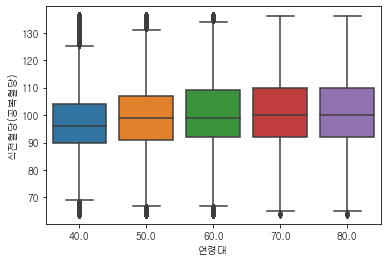

In [50]:
distributions(data,'식전혈당(공복혈당)',1)

10.총 콜레스테롤 , HDL 콜레스테롤, LDL 콜레스테롤, 트리글리세라이드은 모두 결측치가 절반이 넘어가므로 사용하지 않음.


혈색소

In [51]:
data_about(data,'혈색소')
del_nan(data,'혈색소')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892819 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   혈색소     892807 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    892807.000000
mean         14.209003
std           1.554578
min           1.000000
25%          13.200000
50%          14.200000
75%          15.300000
max          25.000000
Name: 혈색소, dtype: float64

218152   NaN
226760   NaN
268222   NaN
344219   NaN
401803   NaN
478012   NaN
537829   NaN
568472   NaN
949047   NaN
970858   NaN
Name: 혈색소, dtype: float64

결측치 개수 : 12

543537    1.0
831410    1.3
404487    2.8
102319    3.1
315986    3.3
216516    3.4
571815    3.5
922308    3.6
615228    3.6
231555    3.8
Name: 혈색소, dtype: float64

삭제한 결측치 개수 : 혈색소    12
dtype: int64


In [52]:
data_about(data,'혈색소')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892807 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   혈색소     892807 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    892807.000000
mean         14.209003
std           1.554578
min           1.000000
25%          13.200000
50%          14.200000
75%          15.300000
max          25.000000
Name: 혈색소, dtype: float64

950491    22.3
580173    22.5
467160    22.7
665582    22.9
815562    23.0
433218    23.1
136571    23.9
336105    24.1
24636     24.6
41042     25.0
Name: 혈색소, dtype: float64

543537    1.0
831410    1.3
404487    2.8
102319    3.1
315986    3.3
216516    3.4
571815    3.5
922308    3.6
615228    3.6
231555    3.8
Name: 혈색소, dtype: float64



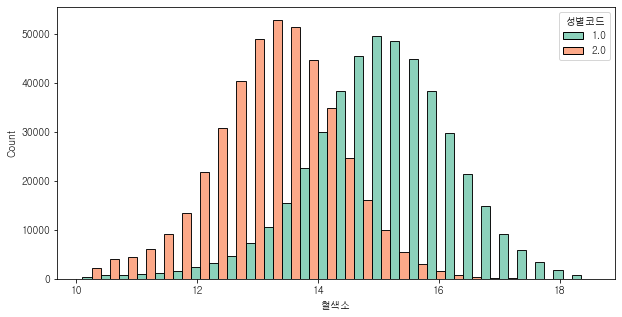

남자 평균: 15.154185392578041
남자 표준편차: 1.1893727072534654
여자 평균 13.30339032956864
여자 표준편차: 1.0363774068593459
평균차이/표준편차의평균 1.6320412771713428
40.0 대 평균: 14.442653805602259
40.0 대 표준편차 1.5082646701012
50.0 대 평균: 14.342234055941855
50.0 대 표준편차 1.3306298232349896
60.0 대 평균: 14.098770240024146
60.0 대 표준편차 1.346371341485344
70.0 대 평균: 13.592489711934158
70.0 대 표준편차 1.379890406479474
80.0 대 평균: 13.233698641382423
80.0 대 표준편차 1.407061037224531


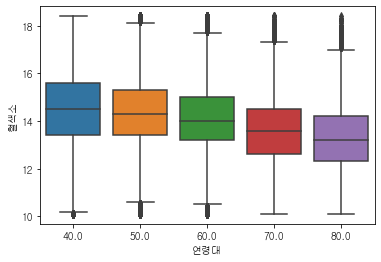

In [53]:
distributions(data,'혈색소',0.3)

In [54]:
age_ft.append('혈색소')

요단백 -> 연령대 별 비율이 비슷해보임 사용 x

In [55]:
data_about(data,'요단백')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892807 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   요단백     888713 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    888713.000000
mean          1.122406
std           0.493442
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: 요단백, dtype: float64

995869   NaN
996833   NaN
996906   NaN
997705   NaN
998248   NaN
998296   NaN
998399   NaN
998862   NaN
999078   NaN
999596   NaN
Name: 요단백, dtype: float64

결측치 개수 : 4094

0         1.0
653903    1.0
653905    1.0
653906    1.0
653907    1.0
653908    1.0
653909    1.0
653910    1.0
653911    1.0
653912    1.0
Name: 요단백, dtype: float64



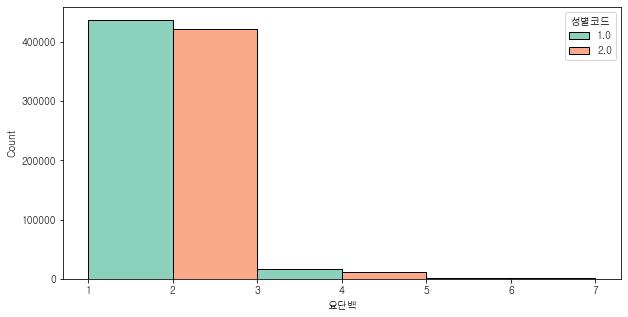

남자 평균: 1.1437941805752645
남자 표준편차: 0.5396526711910542
여자 평균 1.0999448646877934
여자 표준편차: 0.43859432775769697
평균차이/표준편차의평균 0.0906582583448287


In [56]:
distribution_sex(data,'요단백')

In [57]:
del_nan(data,'요단백')

삭제한 결측치 개수 : 요단백    4094
dtype: int64


<AxesSubplot:xlabel='연령대', ylabel='Count'>

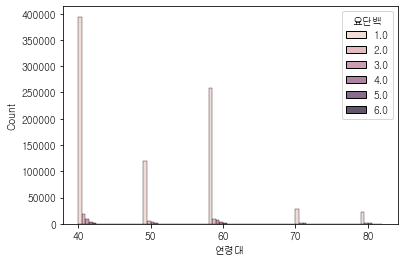

In [137]:
sns.histplot(data,x='연령대',hue='요단백',multiple='dodge',binwidth=3)

혈장크레아틴 : 0.8~1.7이 정상치 ● 음식물에 관계없이 근육의 발육과 운동에 관계함 -> 성별,나이 모두에 영향 갈 것  

In [59]:
data_about(data,'혈청크레아티닌')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888713 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   혈청크레아티닌  888713 non-null  float64
dtypes: float64(1)
memory usage: 45.8 MB
None

count    888713.000000
mean          0.849718
std           0.343507
min           0.000000
25%           0.700000
50%           0.800000
75%           1.000000
max          95.000000
Name: 혈청크레아티닌, dtype: float64

57016     19.2
197925    19.7
402138    24.0
75195     25.0
67563     26.0
629051    27.0
643585    29.0
230543    60.0
503986    68.0
634329    95.0
Name: 혈청크레아티닌, dtype: float64

958063    0.00
324403    0.04
970937    0.04
148139    0.04
411566    0.05
198925    0.05
969686    0.05
294551    0.05
490765    0.05
3132      0.05
Name: 혈청크레아티닌, dtype: float64



In [60]:
del_nan(data,'혈청크레아티닌')

삭제한 결측치 개수 : 혈청크레아티닌    0
dtype: int64


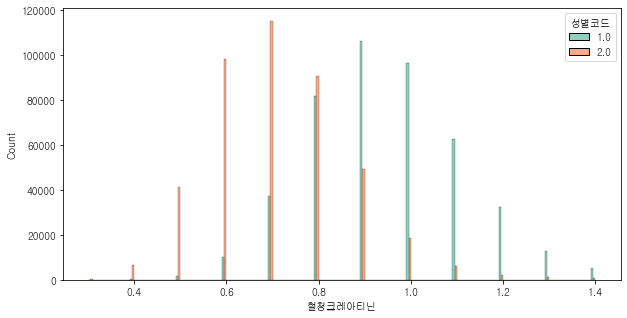

남자 평균: 0.9453176269793044
남자 표준편차: 0.16676699008064466
여자 평균 0.7205723940058311
여자 표준편차: 0.15202016761140572
평균차이/표준편차의평균 1.4223265656151731
40.0 대 평균: 0.8335496719609602
40.0 대 표준편차 0.19074997147591724
50.0 대 평균: 0.827256401939766
50.0 대 표준편차 0.1907831213584053
60.0 대 평균: 0.8331210757105605
60.0 대 표준편차 0.19874549064580427
70.0 대 평균: 0.8658138918345705
70.0 대 표준편차 0.21265307256920807
80.0 대 평균: 0.8863161529828197
80.0 대 표준편차 0.22297579481216212


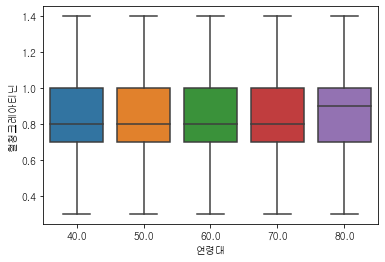

In [61]:
distributions(data,'혈청크레아티닌',0.01)

In [62]:
age_ft.append('혈청크레아티닌')

11.(혈청지오티)AST(0~40이 정상치임)

In [63]:
data_about(data,'(혈청지오티)AST')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888713 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   (혈청지오티)AST  888713 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    888713.000000
mean         27.692573
std          24.069943
min           1.000000
25%          20.000000
50%          24.000000
75%          30.000000
max        8270.000000
Name: (혈청지오티)AST, dtype: float64

91485     2432.0
231759    2584.0
146789    2864.0
39901     2993.0
532216    3084.0
515827    3315.0
177479    3571.0
557038    4360.0
764766    5659.0
310369    8270.0
Name: (혈청지오티)AST, dtype: float64

658095    1.0
831837    1.0
259849    1.0
788823    1.0
443092    1.0
860957    1.0
494983    1.0
595196    2.0
917827    2.0
487426    2.0
Name: (혈청지오티)AST, dtype: float64



In [64]:
data[data['(혈청지오티)AST']>200]

,성별코드,연령대,신장(5Cm단위),체중(5Kg 단위),허리둘레,수축기 혈압,이완기 혈압,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석,시력
949,2.0,40.0,150.0,40.0,65.0,113.0,76.0,78.0,227.0,50.0,...,0.9,334.0,134.0,17.0,1.0,1.0,0.0,NaN,NaN,2.4
1361,2.0,50.0,155.0,55.0,87.0,130.0,79.0,109.0,NaN,NaN,...,0.6,255.0,148.0,966.0,3.0,1.0,0.0,NaN,NaN,1.0
2646,1.0,60.0,165.0,60.0,90.5,122.0,76.0,102.0,166.0,117.0,...,0.8,484.0,363.0,235.0,3.0,1.0,0.0,NaN,NaN,1.6
3305,1.0,40.0,175.0,65.0,82.0,142.0,96.0,98.0,179.0,441.0,...,0.9,221.0,119.0,537.0,3.0,1.0,1.0,0.0,0.0,1.8
3507,1.0,40.0,185.0,95.0,103.0,99.0,68.0,127.0,NaN,NaN,...,1.2,330.0,420.0,272.0,3.0,1.0,0.0,NaN,NaN,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996537,2.0,40.0,155.0,60.0,71.0,127.0,98.0,95.0,163.0,375.0,...,0.8,302.0,280.0,443.0,1.0,1.0,1.0,1.0,0.0,1.7
997130,1.0,50.0,160.0,45.0,74.0,90.0,60.0,122.0,NaN,NaN,...,0.9,410.0,232.0,999.0,3.0,1.0,0.0,NaN,NaN,2.2
997892,2.0,40.0,150.0,60.0,83.0,152.0,98.0,95.0,NaN,NaN,...,0.7,274.0,52.0,998.0,1.0,1.0,1.0,0.0,2.0,2.2
998013,1.0,50.0,160.0,55.0,74.0,124.0,67.0,210.0,NaN,NaN,...,1.0,304.0,148.0,999.0,3.0,1.0,0.0,NaN,NaN,1.9


In [65]:
data_about(data,'(혈청지오티)ALT')
del_nan(data,'(혈청지오티)ALT')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888713 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   (혈청지오티)ALT  888712 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    888712.000000
mean         26.776164
std          26.005341
min           1.000000
25%          16.000000
50%          21.000000
75%          31.000000
max        5990.000000
Name: (혈청지오티)ALT, dtype: float64

193230    2294.0
256431    2474.0
756842    2529.0
764766    2714.0
231759    2772.0
557038    3461.0
177479    3870.0
146789    4236.0
310369    5990.0
490405       NaN
Name: (혈청지오티)ALT, dtype: float64

결측치 개수 : 1

598429    1.0
349562    1.0
588470    1.0
243741    1.0
601088    1.0
371892    1.0
696060    1.0
657526    1.0
754029    1.0
156739    1.0
Name: (혈청지오티)ALT, dtype: float64

삭제한 결측치 개수 : (혈청지오티)ALT    1
dtype: int64


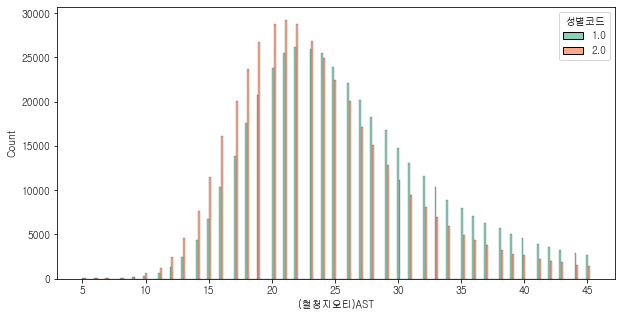

남자 평균: 25.73011056790065
남자 표준편차: 7.001884890645264
여자 평균 23.73348731244377
여자 표준편차: 6.549516528146373
평균차이/표준편차의평균 0.298707094332
40.0 대 평균: 23.78151929503193
40.0 대 표준편차 6.9269324625212025
50.0 대 평균: 25.338871436491004
50.0 대 표준편차 6.636773902471751
60.0 대 평균: 25.868041961551974
60.0 대 표준편차 6.681152781754546
70.0 대 평균: 25.407551906635906
70.0 대 표준편차 6.616480513326242
80.0 대 평균: 24.693921760183493
80.0 대 표준편차 6.509332681102571


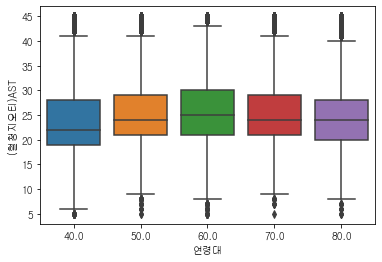

In [66]:
distributions(data,'(혈청지오티)AST',0.3)

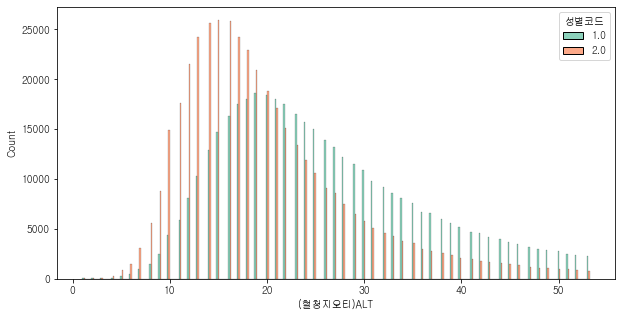

남자 평균: 25.631038847452686
남자 표준편차: 10.194283458554693
여자 평균 19.96781309875912
여자 표준편차: 8.82854549679886
평균차이/표준편차의평균 0.6254682777156636
40.0 대 평균: 22.67146746626074
40.0 대 표준편차 10.508617361440344
50.0 대 평균: 23.681755567844753
50.0 대 표준편차 9.617370466677098
60.0 대 평균: 23.155852677306637
60.0 대 표준편차 9.348281704081746
70.0 대 평균: 20.611200631392023
70.0 대 표준편차 8.66868808716882
80.0 대 평균: 18.549247062717196
80.0 대 표준편차 8.254047156154572


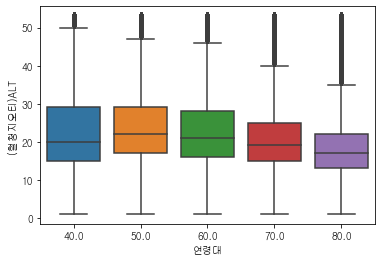

In [67]:
distributions(data,'(혈청지오티)ALT',0.3)

In [68]:
age_ft.append('(혈청지오티)ALT')

In [69]:
data_about(data,'감마 지티피')
del_nan(data,'감마 지티피')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888712 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   감마 지티피  888712 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    888712.000000
mean         37.802408
std          51.851528
min           1.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2630.000000
Name: 감마 지티피, dtype: float64

743686    1049.0
426075    1063.0
397739    1173.0
52911     1177.0
263439    1721.0
202980    1731.0
714820    2159.0
719863    2291.0
629       2322.0
967236    2630.0
Name: 감마 지티피, dtype: float64

404895    1.0
848837    1.0
586827    1.0
850567    1.0
595163    1.0
18405     1.0
506997    1.0
900585    1.0
92330     1.0
959756    1.0
Name: 감마 지티피, dtype: float64

삭제한 결측치 개수 : 감마 지티피    0
dtype: int64


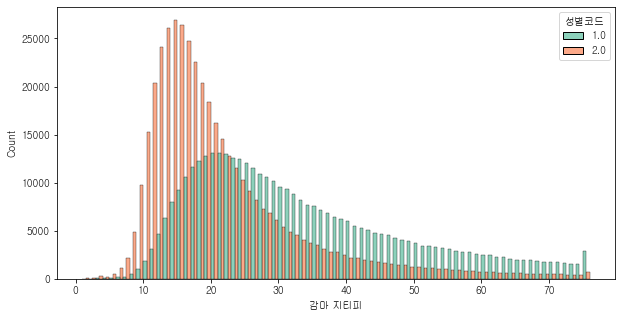

남자 평균: 32.75413987487787
남자 표준편차: 15.611500266221336
여자 평균 21.367876864729396
여자 표준편차: 12.000624706820332
평균차이/표준편차의평균 0.9184866463604459
40.0 대 평균: 27.305334472976305
40.0 대 표준편차 15.840187581053394
50.0 대 평균: 27.792978837257476
50.0 대 표준편차 15.039188203798261
60.0 대 평균: 26.426698468877433
60.0 대 표준편차 13.981543990140281
70.0 대 평균: 24.29810878661088
70.0 대 표준편차 12.678233289993836
80.0 대 평균: 23.068185468532057
80.0 대 표준편차 12.51214009036044


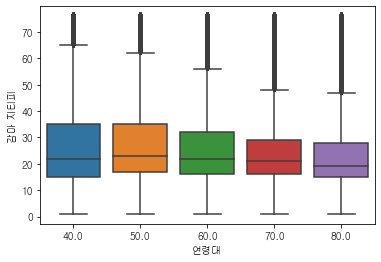

In [70]:
distributions(data,'감마 지티피',1)

In [71]:
age_ft.append('감마 지티피')

흡연상태  
성별 : 꽤나 유의한 차이를 보임  
연령대 : 감소하는 추세를 보임  

In [72]:
# 성별을 보면 이전에 피움 + 현재도 피움으로 합쳐도 될듯
# 연령대를 보면 이전에 피움이랑 합치면 안됨.

In [73]:
data_about(data,'흡연상태')
del_nan(data,'흡연상태')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888712 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   흡연상태    888403 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    888403.000000
mean          1.559477
std           0.784451
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: 흡연상태, dtype: float64

960911   NaN
961828   NaN
973118   NaN
976111   NaN
979041   NaN
980578   NaN
986330   NaN
987967   NaN
990738   NaN
998233   NaN
Name: 흡연상태, dtype: float64

결측치 개수 : 309

0         1.0
589607    1.0
589608    1.0
589610    1.0
589615    1.0
589616    1.0
589618    1.0
589621    1.0
589606    1.0
589623    1.0
Name: 흡연상태, dtype: float64

삭제한 결측치 개수 : 흡연상태    309
dtype: int64


In [74]:
data_about(data,'흡연상태')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888403 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   흡연상태    888403 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    888403.000000
mean          1.559477
std           0.784451
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: 흡연상태, dtype: float64

829799    3.0
829800    3.0
106471    3.0
106470    3.0
580969    3.0
580968    3.0
829807    3.0
106468    3.0
829768    3.0
692395    3.0
Name: 흡연상태, dtype: float64

0         1.0
589607    1.0
589608    1.0
589610    1.0
589615    1.0
589616    1.0
589618    1.0
589621    1.0
589606    1.0
589623    1.0
Name: 흡연상태, dtype: float64



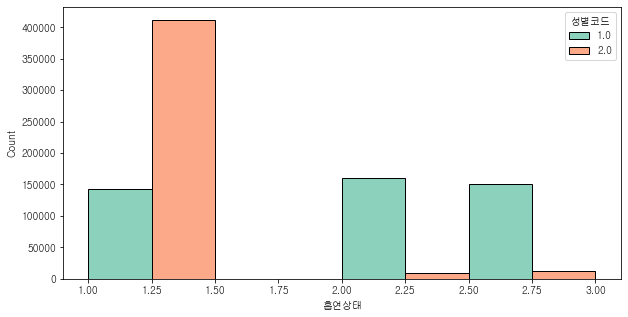

남자 평균: 2.016570530779964
남자 표준편차: 0.804180995199536
여자 평균 1.0794220410876076
여자 표준편차: 0.3640916695034542
평균차이/표준편차의평균 1.6837759199853
40.0 대 평균: 1.6674051827416998
40.0 대 표준편차 0.8405383175634469
50.0 대 평균: 1.5598997414964917
50.0 대 표준편차 0.7818515050282858
60.0 대 평균: 1.450492278546415
60.0 대 표준편차 0.702921807656552
70.0 대 평균: 1.3044006652168352
70.0 대 표준편차 0.5766957088371957
80.0 대 평균: 1.2452799545251532
80.0 대 표준편차 0.5213978956424528


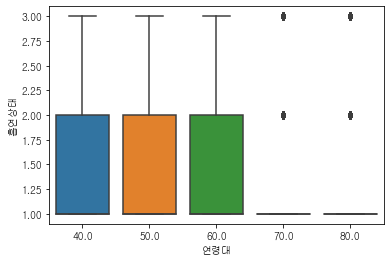

In [75]:
distributions(data,'흡연상태',0.5)

<AxesSubplot:xlabel='연령대', ylabel='Count'>

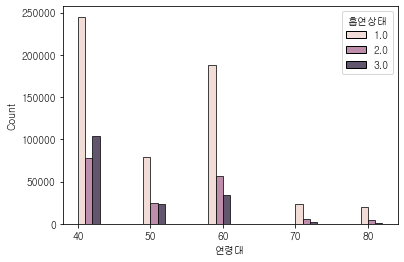

In [76]:
sns.histplot(data,x='연령대',hue='흡연상태',multiple='dodge',binwidth=3)

In [77]:
age_ft.append('흡연상태')

음주여부  
성별 : 꽤나 유의미한 차이  
연령대 : 빠르게 감소하는 추세를 보임

In [78]:
data_about(data,'음주여부')
del_nan(data,'음주여부')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888403 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   음주여부    888272 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB
None

count    888272.000000
mean          0.588271
std           0.492147
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: 음주여부, dtype: float64

936069   NaN
945588   NaN
946495   NaN
953428   NaN
957258   NaN
962353   NaN
986762   NaN
992340   NaN
994708   NaN
998310   NaN
Name: 음주여부, dtype: float64

결측치 개수 : 131

0         0.0
526933    0.0
526932    0.0
526931    0.0
526928    0.0
526927    0.0
526926    0.0
526922    0.0
526919    0.0
526917    0.0
Name: 음주여부, dtype: float64

삭제한 결측치 개수 : 음주여부    131
dtype: int64


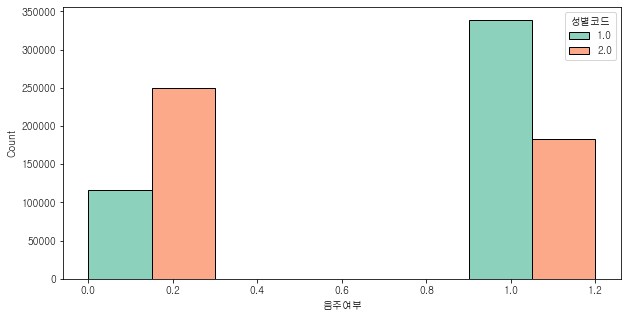

남자 평균: 0.7448630212247876
남자 표준편차: 0.4359386636687842
여자 평균 0.4238016979120022
여자 표준편차: 0.49416028007965906
평균차이/표준편차의평균 0.690381008323391


In [79]:
distribution_sex(data,'음주여부',0.3)

<AxesSubplot:xlabel='연령대', ylabel='Count'>

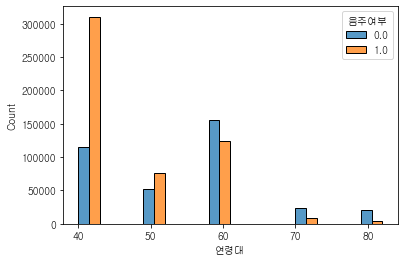

In [80]:
sns.histplot(data,x='연령대',hue='음주여부',multiple='dodge',binwidth=3)

In [81]:
sex_ft.append('음주여부')
age_ft.append('음주여부')

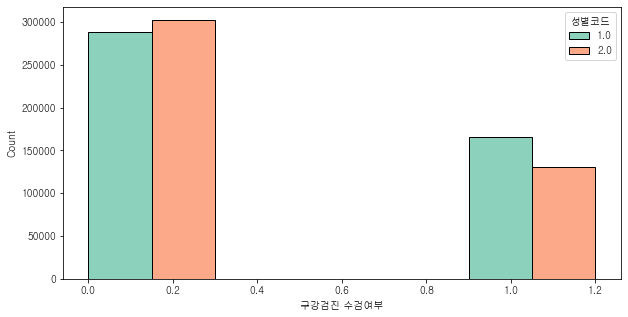

남자 평균: 0.3652913848195959
남자 표준편차: 0.4815123036097314
여자 평균 0.3016909874018438
여자 표준편차: 0.4589923984121577
평균차이/표준편차의평균 0.13524737788343758


In [138]:
distribution_sex(data,'구강검진 수검여부',0.3)

<AxesSubplot:xlabel='연령대', ylabel='Count'>

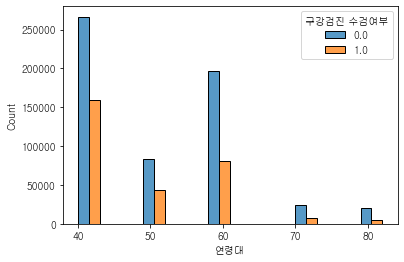

In [140]:
sns.histplot(data,x='연령대',hue='구강검진 수검여부',multiple='dodge',binwidth=3)

치석  
성별 : 차이가 꽤 있음  
연령대 : 연령대가 올라감에 따라 감소하는 추세를 보임

In [83]:
print(data['치아우식증유무'].isnull().sum())
print(data['치석'].isnull().sum())

591349
591350


In [84]:
#결측치 많은 데이터 제거
data.drop(['치아우식증유무','치석','총 콜레스테롤','트리글리세라이드','HDL 콜레스테롤','LDL 콜레스테롤'],axis=1,inplace=True)
data_test.drop(['치아우식증유무','치석','총 콜레스테롤','트리글리세라이드','HDL 콜레스테롤','LDL 콜레스테롤'],axis=1,inplace=True)

In [85]:
sex_rank

,영향도
신장(5Cm단위),2.078642
체중(5Kg 단위),1.367867
허리둘레,0.925227
연령대,0.120495
시력(우),0.307245
시력(좌),0.291303
시력,0.318406
수축기 혈압,0.264784
이완기 혈압,0.357729
식전혈당(공복혈당),0.288363


# 모델링

### 1. 성별 데이터셋 만들기 (위에서 판단한 기준)

In [87]:
sex_ft=sex_rank[sex_rank['영향도']>0.5].index
gender_train_X=data[sex_ft]
gender_train_target=data['성별코드']
gender_test_X =data_test[sex_ft]
gender_test_target = data_test['성별코드']

### 2. 연령대 첫번째 데이터셋 만들기 ( XGB 모델의 permutation importance 이용)

In [88]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#모델 저장용
import joblib

In [89]:
#연령대와 성별 그리고 일부 특성을 제외한 데이터셋 생성
X = data.iloc[:,2:]
Y = data['연령대']

#학습 비율 동일하게하기위해 stratify=True
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=0)

In [100]:
XGB = XGBClassifier()
XGB.fit(x_train,y_train)

joblib.dump(XGB,'./XGB_for_featureSelection.pkl')

perImportance = PermutationImportance(XGB,scoring='accuracy',random_state=0)
perImportance.fit(x_valid,y_valid)
show_weights(perImportance, feature_names=list(x_valid.columns))

C:\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [127]:
def accuracy(true, pred):   
    score = np.mean(true==pred)
    return score

accuracy(XGB.predict(x_valid),y_valid)

0.6479243477526667

In [125]:
#PermutationImportance 0.1 이상 10개
age_importance_ft = ['체중(5Kg 단위)','허리둘레','수축기 혈압','시력','(혈청지오티)AST',
                    '이완기 혈압','음주여부','(혈청지오티)ALT','신장(5Cm단위)','혈청크레아티닌']

age_train_X=data[age_importance_ft]
age_train_target=data['연령대']
age_test_X =data_test[age_importance_ft]
age_test_target = data_test['연령대']

### 3.연령대 두번째 데이터셋 만들기 (위에서 판단한 기준)

In [90]:
age2_train_X=data[age_ft]
age2_train_target=data['연령대']
age2_test_X =data_test[age_ft]
age2_test_target = data_test['연령대']

### 4. 모델학습 및 평가

In [94]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import time

### 4-1. 성별 판별 모델

In [ ]:
model_rank = pd.DataFrame(columns={'accuracy','F1score','learning time(s)'})

반복문을 통해 코드를 돌릴 시 메모리 오류로 따로따로 학습

In [116]:
#성별 판별 학습
(X,Y) = (gender_train_X,gender_train_target)

#나중에 활용할 수 있게 고정
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2,shuffle=True, stratify=Y, random_state=0)

rf = RandomForestClassifier(n_estimators=200,random_state=0)


start = time.time()
rf.fit(x_train,y_train)
joblib.dump(rf,'./rf_gender.pkl')

#모델 학습시간
learning_times= time.time()-start

predict_valid = rf.predict(x_valid)

print('모델 학습시간',learning_times),print()
print(classification_report(y_valid,predict_valid))


#랜덤포레스트는 결측값을 받지 않으므로 학습 데이터의 평균으로 테스트 데이터의 nan값 대치
predict=rf.predict(gender_test_X.fillna(gender_train_X.mean()))
print('실제데이터셋')
print(classification_report(gender_test_target,predict))

모델 학습시간 538.8645713329315
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95     91007
         2.0       0.95      0.95      0.95     86648

    accuracy                           0.95    177655
   macro avg       0.95      0.95      0.95    177655
weighted avg       0.95      0.95      0.95    177655

실제데이터셋
              precision    recall  f1-score   support

           1       0.96      0.95      0.95     51090
           2       0.95      0.96      0.95     48910

    accuracy                           0.95    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [112]:
model_rank.loc['rf_gender_valid'] = {'accuracy':0.95,'F1score':0.95,'learning time(s)':538}
model_rank.loc['rf_gender_test'] = {'accuracy':0.95,'F1score':0.95,'learning time(s)':538}

In [117]:
#성별 학습
(X,Y) = (gender_train_X,gender_train_target)

#나중에 활용할 수 있게 고정
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2,shuffle=True, stratify=Y, random_state=0)

xgb = XGBClassifier(n_estimators=300,random_state=0)


start = time.time()
xgb.fit(x_train,y_train)
joblib.dump(xgb,'./xgb_gender.pkl')

#모델 학습시간
learning_times= time.time()-start

predict_valid = xgb.predict(x_valid)

print('모델 학습시간',learning_times)
print(classification_report(y_valid,predict_valid))

#XGB는 결측값 처리를 자동으로 해줌, 따라서 결측값 대치 X
predict=xgb.predict(gender_test_X)
print('실제데이터셋')
print(classification_report(gender_test_target,predict))

C:\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:24:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
모델 학습시간 131.69954347610474
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95     91007
         2.0       0.95      0.96      0.95     86648

    accuracy                           0.95    177655
   macro avg       0.95      0.95      0.95    177655
weighted avg       0.95      0.95      0.95    177655

실제데이터셋
              precision    recall  f1-score   support

           1       0.96      0.95      0.95     51090
           2       0.94      0.96      0.95     48910

    accuracy                           0.95    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [118]:
model_rank.loc['xgb_gender_valid'] = {'accuracy':0.95,'F1score':0.95,'learning time(s)':131}
model_rank.loc['xgb_gender_test'] = {'accuracy':0.95,'F1score':0.95,'learning time(s)':131}

In [119]:
#성별 학습
(X,Y) = (gender_train_X,gender_train_target)

#나중에 활용할 수 있게 고정
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2,shuffle=True, stratify=Y, random_state=0)

cat = CatBoostClassifier()


start = time.time()
cat.fit(x_train,y_train)
joblib.dump(cat,'./cat_gender.pkl')

#모델 학습시간
learning_times= time.time()-start

predict_valid = cat.predict(x_valid)

print('모델 학습시간',learning_times)
print(classification_report(y_valid,predict_valid))


#CAT는 결측값 처리를 자동으로 해줌, 따라서 결측값 대치 X
predict=cat.predict(gender_test_X)
print('실제데이터셋')
print(classification_report(gender_test_target,predict))

Learning rate set to 0.170052
0:	learn: 0.4285396	total: 333ms	remaining: 5m 33s
1:	learn: 0.3002905	total: 513ms	remaining: 4m 15s
2:	learn: 0.2326780	total: 643ms	remaining: 3m 33s
3:	learn: 0.1982485	total: 776ms	remaining: 3m 13s
4:	learn: 0.1765888	total: 900ms	remaining: 2m 59s
5:	learn: 0.1636102	total: 1.02s	remaining: 2m 48s
6:	learn: 0.1549931	total: 1.15s	remaining: 2m 42s
7:	learn: 0.1486677	total: 1.28s	remaining: 2m 38s
8:	learn: 0.1445326	total: 1.4s	remaining: 2m 34s
9:	learn: 0.1412218	total: 1.55s	remaining: 2m 34s
10:	learn: 0.1386808	total: 1.71s	remaining: 2m 34s
11:	learn: 0.1367608	total: 1.85s	remaining: 2m 32s
12:	learn: 0.1354230	total: 1.98s	remaining: 2m 30s
13:	learn: 0.1340373	total: 2.1s	remaining: 2m 27s
14:	learn: 0.1328774	total: 2.23s	remaining: 2m 26s
15:	learn: 0.1319962	total: 2.36s	remaining: 2m 25s
16:	learn: 0.1311355	total: 2.49s	remaining: 2m 24s
17:	learn: 0.1303643	total: 2.6s	remaining: 2m 22s
18:	learn: 0.1297162	total: 2.74s	remaining: 2m

160:	learn: 0.1172579	total: 21.5s	remaining: 1m 51s
161:	learn: 0.1172479	total: 21.6s	remaining: 1m 51s
162:	learn: 0.1172336	total: 21.7s	remaining: 1m 51s
163:	learn: 0.1172162	total: 21.9s	remaining: 1m 51s
164:	learn: 0.1171971	total: 22s	remaining: 1m 51s
165:	learn: 0.1171801	total: 22.1s	remaining: 1m 51s
166:	learn: 0.1171641	total: 22.3s	remaining: 1m 51s
167:	learn: 0.1171450	total: 22.4s	remaining: 1m 50s
168:	learn: 0.1171265	total: 22.5s	remaining: 1m 50s
169:	learn: 0.1171187	total: 22.7s	remaining: 1m 50s
170:	learn: 0.1171023	total: 22.8s	remaining: 1m 50s
171:	learn: 0.1170891	total: 22.9s	remaining: 1m 50s
172:	learn: 0.1170742	total: 23s	remaining: 1m 50s
173:	learn: 0.1170599	total: 23.2s	remaining: 1m 50s
174:	learn: 0.1170408	total: 23.3s	remaining: 1m 49s
175:	learn: 0.1170295	total: 23.5s	remaining: 1m 49s
176:	learn: 0.1170114	total: 23.6s	remaining: 1m 49s
177:	learn: 0.1170076	total: 23.7s	remaining: 1m 49s
178:	learn: 0.1169893	total: 23.9s	remaining: 1m 4

316:	learn: 0.1154681	total: 41.9s	remaining: 1m 30s
317:	learn: 0.1154596	total: 42s	remaining: 1m 30s
318:	learn: 0.1154527	total: 42.2s	remaining: 1m 30s
319:	learn: 0.1154436	total: 42.3s	remaining: 1m 29s
320:	learn: 0.1154383	total: 42.4s	remaining: 1m 29s
321:	learn: 0.1154313	total: 42.6s	remaining: 1m 29s
322:	learn: 0.1154228	total: 42.7s	remaining: 1m 29s
323:	learn: 0.1154151	total: 42.8s	remaining: 1m 29s
324:	learn: 0.1154079	total: 43s	remaining: 1m 29s
325:	learn: 0.1154015	total: 43.1s	remaining: 1m 29s
326:	learn: 0.1153923	total: 43.2s	remaining: 1m 28s
327:	learn: 0.1153780	total: 43.4s	remaining: 1m 28s
328:	learn: 0.1153654	total: 43.5s	remaining: 1m 28s
329:	learn: 0.1153558	total: 43.6s	remaining: 1m 28s
330:	learn: 0.1153495	total: 43.8s	remaining: 1m 28s
331:	learn: 0.1153417	total: 43.9s	remaining: 1m 28s
332:	learn: 0.1153324	total: 44s	remaining: 1m 28s
333:	learn: 0.1153222	total: 44.2s	remaining: 1m 28s
334:	learn: 0.1153141	total: 44.3s	remaining: 1m 27s

472:	learn: 0.1143190	total: 1m 2s	remaining: 1m 9s
473:	learn: 0.1143070	total: 1m 2s	remaining: 1m 9s
474:	learn: 0.1142999	total: 1m 2s	remaining: 1m 8s
475:	learn: 0.1142930	total: 1m 2s	remaining: 1m 8s
476:	learn: 0.1142832	total: 1m 2s	remaining: 1m 8s
477:	learn: 0.1142720	total: 1m 2s	remaining: 1m 8s
478:	learn: 0.1142690	total: 1m 2s	remaining: 1m 8s
479:	learn: 0.1142625	total: 1m 3s	remaining: 1m 8s
480:	learn: 0.1142551	total: 1m 3s	remaining: 1m 8s
481:	learn: 0.1142385	total: 1m 3s	remaining: 1m 8s
482:	learn: 0.1142210	total: 1m 3s	remaining: 1m 7s
483:	learn: 0.1142088	total: 1m 3s	remaining: 1m 7s
484:	learn: 0.1142038	total: 1m 3s	remaining: 1m 7s
485:	learn: 0.1141948	total: 1m 3s	remaining: 1m 7s
486:	learn: 0.1141908	total: 1m 3s	remaining: 1m 7s
487:	learn: 0.1141797	total: 1m 4s	remaining: 1m 7s
488:	learn: 0.1141697	total: 1m 4s	remaining: 1m 7s
489:	learn: 0.1141530	total: 1m 4s	remaining: 1m 7s
490:	learn: 0.1141500	total: 1m 4s	remaining: 1m 6s
491:	learn: 

629:	learn: 0.1131311	total: 1m 23s	remaining: 49.2s
630:	learn: 0.1131195	total: 1m 23s	remaining: 49s
631:	learn: 0.1131130	total: 1m 23s	remaining: 48.9s
632:	learn: 0.1131093	total: 1m 24s	remaining: 48.8s
633:	learn: 0.1131019	total: 1m 24s	remaining: 48.6s
634:	learn: 0.1130989	total: 1m 24s	remaining: 48.5s
635:	learn: 0.1130939	total: 1m 24s	remaining: 48.3s
636:	learn: 0.1130864	total: 1m 24s	remaining: 48.2s
637:	learn: 0.1130738	total: 1m 24s	remaining: 48.1s
638:	learn: 0.1130688	total: 1m 24s	remaining: 47.9s
639:	learn: 0.1130649	total: 1m 24s	remaining: 47.8s
640:	learn: 0.1130566	total: 1m 25s	remaining: 47.7s
641:	learn: 0.1130529	total: 1m 25s	remaining: 47.5s
642:	learn: 0.1130492	total: 1m 25s	remaining: 47.4s
643:	learn: 0.1130442	total: 1m 25s	remaining: 47.3s
644:	learn: 0.1130371	total: 1m 25s	remaining: 47.1s
645:	learn: 0.1130313	total: 1m 25s	remaining: 47s
646:	learn: 0.1130313	total: 1m 25s	remaining: 46.8s
647:	learn: 0.1130286	total: 1m 25s	remaining: 46.

785:	learn: 0.1121155	total: 1m 43s	remaining: 28.1s
786:	learn: 0.1121124	total: 1m 43s	remaining: 28s
787:	learn: 0.1121024	total: 1m 43s	remaining: 27.8s
788:	learn: 0.1120973	total: 1m 43s	remaining: 27.7s
789:	learn: 0.1120942	total: 1m 43s	remaining: 27.6s
790:	learn: 0.1120913	total: 1m 43s	remaining: 27.4s
791:	learn: 0.1120846	total: 1m 44s	remaining: 27.3s
792:	learn: 0.1120781	total: 1m 44s	remaining: 27.2s
793:	learn: 0.1120754	total: 1m 44s	remaining: 27s
794:	learn: 0.1120711	total: 1m 44s	remaining: 26.9s
795:	learn: 0.1120690	total: 1m 44s	remaining: 26.8s
796:	learn: 0.1120636	total: 1m 44s	remaining: 26.7s
797:	learn: 0.1120612	total: 1m 44s	remaining: 26.5s
798:	learn: 0.1120560	total: 1m 44s	remaining: 26.4s
799:	learn: 0.1120557	total: 1m 44s	remaining: 26.2s
800:	learn: 0.1120520	total: 1m 45s	remaining: 26.1s
801:	learn: 0.1120456	total: 1m 45s	remaining: 26s
802:	learn: 0.1120385	total: 1m 45s	remaining: 25.9s
803:	learn: 0.1120294	total: 1m 45s	remaining: 25.7s

943:	learn: 0.1112075	total: 2m 3s	remaining: 7.35s
944:	learn: 0.1112071	total: 2m 4s	remaining: 7.22s
945:	learn: 0.1111981	total: 2m 4s	remaining: 7.09s
946:	learn: 0.1111968	total: 2m 4s	remaining: 6.96s
947:	learn: 0.1111931	total: 2m 4s	remaining: 6.83s
948:	learn: 0.1111881	total: 2m 4s	remaining: 6.7s
949:	learn: 0.1111816	total: 2m 4s	remaining: 6.57s
950:	learn: 0.1111773	total: 2m 4s	remaining: 6.43s
951:	learn: 0.1111737	total: 2m 4s	remaining: 6.3s
952:	learn: 0.1111681	total: 2m 5s	remaining: 6.17s
953:	learn: 0.1111606	total: 2m 5s	remaining: 6.04s
954:	learn: 0.1111571	total: 2m 5s	remaining: 5.91s
955:	learn: 0.1111498	total: 2m 5s	remaining: 5.78s
956:	learn: 0.1111436	total: 2m 5s	remaining: 5.65s
957:	learn: 0.1111380	total: 2m 5s	remaining: 5.51s
958:	learn: 0.1111346	total: 2m 5s	remaining: 5.38s
959:	learn: 0.1111230	total: 2m 6s	remaining: 5.25s
960:	learn: 0.1111159	total: 2m 6s	remaining: 5.12s
961:	learn: 0.1111079	total: 2m 6s	remaining: 4.99s
962:	learn: 0.

In [122]:
model_rank.loc['cat_gender_valid'] = {'accuracy':0.95,'F1score':0.95,'learning time(s)':132}
model_rank.loc['cat_gender_test'] = {'accuracy':0.95,'F1score':0.95,'learning time(s)':132}

In [123]:
model_rank

,learning time(s),accuracy,F1score
rf_gender_valid,538,0.95,0.95
rf_gender_test,538,0.95,0.95
xgb_gender_valid,131,0.95,0.95
xgb_gender_test,131,0.95,0.95
cat_gender_valid,132.0,0.95,0.95
cat_gender_test,132.0,0.95,0.95


### 4-2 연령대 추측 모델 (XGB와 CATBoost)

In [124]:
model_rank_age = pd.DataFrame(columns={'accuracy','F1score','learning time(s)'})

In [132]:
#연령대 학습
(X,Y) = (age_train_X,age_train_target)

#나중에 활용할 수 있게 고정
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2,shuffle=True, stratify=Y, random_state=0)

xgb = XGBClassifier(n_estimators=300,random_state=0)


start = time.time()
xgb.fit(x_train,y_train)
joblib.dump(xgb,'./xgb_age.pkl')

#모델 학습시간
learning_times= time.time()-start

predict_valid = xgb.predict(x_valid)

print('모델 학습시간',learning_times)
print(classification_report(y_valid,predict_valid))

#XGB는 결측값 처리를 자동으로 해줌, 따라서 결측값 대치 X
predict=xgb.predict(age_test_X)
print('실제데이터셋')
print(classification_report(age_test_target,predict))

모델 학습시간 898.529586315155
              precision    recall  f1-score   support

        40.0       0.70      0.85      0.77     85298
        50.0       0.24      0.00      0.00     25450
        60.0       0.56      0.70      0.62     55729
        70.0       0.24      0.02      0.03      6253
        80.0       0.48      0.26      0.33      4925

    accuracy                           0.64    177655
   macro avg       0.44      0.37      0.35    177655
weighted avg       0.57      0.64      0.57    177655

실제데이터셋
              precision    recall  f1-score   support

          40       0.69      0.85      0.76     47451
          50       0.07      0.00      0.00     14448
          60       0.55      0.69      0.61     31495
          70       0.23      0.01      0.03      3671
          80       0.46      0.24      0.32      2935

    accuracy                           0.63    100000
   macro avg       0.40      0.36      0.34    100000
weighted avg       0.53      0.63      0.57  

In [ ]:
model_rank.loc['xgb_age1_valid'] = {'accuracy':,'F1score':,'learning time(s)':}
model_rank.loc['xgb_age1_test'] = {'accuracy':,'F1score':,'learning time(s)':}

In [136]:
#성별 학습
(X,Y) = (age_train_X,age_train_target)

#나중에 활용할 수 있게 고정
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2,shuffle=True, stratify=Y, random_state=0)

cat = CatBoostClassifier()


start = time.time()
cat.fit(x_train,y_train)
joblib.dump(cat,'./cat_age.pkl')

#모델 학습시간
learning_times= time.time()-start

predict_valid = cat.predict(x_valid)

print('모델 학습시간',learning_times)
print(classification_report(y_valid,predict_valid))


#CAT는 결측값 처리를 자동으로 해줌, 따라서 결측값 대치 X
predict=cat.predict(age_test_X)
print('실제데이터셋')
print(classification_report(age_test_target,predict))

모델 학습시간 311.11854314804077
              precision    recall  f1-score   support

        40.0       0.70      0.86      0.77     85298
        50.0       0.46      0.00      0.00     25450
        60.0       0.56      0.70      0.62     55729
        70.0       0.20      0.00      0.01      6253
        80.0       0.50      0.27      0.35      4925

    accuracy                           0.64    177655
   macro avg       0.48      0.37      0.35    177655
weighted avg       0.60      0.64      0.57    177655

실제데이터셋
              precision    recall  f1-score   support

          40       0.69      0.86      0.76     47451
          50       0.15      0.00      0.00     14448
          60       0.55      0.69      0.61     31495
          70       0.20      0.00      0.01      3671
          80       0.46      0.27      0.34      2935

    accuracy                           0.63    100000
   macro avg       0.41      0.36      0.34    100000
weighted avg       0.54      0.63      0.57

In [141]:
from sklearn.preprocessing import OneHotEncoder

In [153]:
##성별 학습
#(X,Y) = (age2_train_X,age2_train_target)
#
##나중에 활용할 수 있게 고정
#x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2,shuffle=True, stratify=Y, random_state=0)
#
#cat = CatBoostClassifier()
#
#
#start = time.time()
#cat.fit(x_train,y_train)
#joblib.dump(cat,'./cat_age.pkl')
#
##모델 학습시간
#learning_times= time.time()-start
#
#predict_valid = cat.predict(x_valid)

print('모델 학습시간',learning_times)
print(classification_report(y_valid,predict_valid))


#CAT는 결측값 처리를 자동으로 해줌, 따라서 결측값 대치 X
predict=cat.predict(age2_test_X)
print('실제데이터셋')
print(classification_report(age2_test_target,predict))

모델 학습시간 335.3427007198334
              precision    recall  f1-score   support

        40.0       0.67      0.84      0.75     85298
        50.0       0.17      0.00      0.00     25450
        60.0       0.53      0.66      0.59     55729
        70.0       0.23      0.00      0.00      6253
        80.0       0.49      0.22      0.30      4925

    accuracy                           0.61    177655
   macro avg       0.42      0.34      0.33    177655
weighted avg       0.53      0.61      0.55    177655

실제데이터셋
              precision    recall  f1-score   support

          40       0.66      0.84      0.74     47451
          50       0.29      0.00      0.00     14448
          60       0.53      0.64      0.58     31495
          70       0.44      0.00      0.00      3671
          80       0.45      0.22      0.29      2935

    accuracy                           0.61    100000
   macro avg       0.47      0.34      0.32    100000
weighted avg       0.55      0.61      0.54 

### 위의 결과가 클래스 뷸균형 문제라고 의심 
균형 맞는 데이터셋 만들기

In [161]:
df=data[age_importance_ft]
df['연령대'] = data['연령대']

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_16976/4070614851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['연령대'] = data['연령대']


In [178]:
group=df.groupby('연령대')

balanced=group.get_group(80).head(24000)
balanced=pd.concat([balanced,group.get_group(70).head(24000)], ignore_index=True)

balanced=pd.concat([balanced,group.get_group(60).head(24000)], ignore_index=True)

balanced=pd.concat([balanced,group.get_group(50).head(24000)], ignore_index=True)

balanced=pd.concat([balanced,group.get_group(40).head(24000)], ignore_index=True)

In [180]:
X=balanced[age_importance_ft]
Y=balanced['연령대']

In [182]:
#균형잡힌 연령대 추정
X=balanced[age_importance_ft]
Y=balanced['연령대']

cat = CatBoostClassifier()

start = time.time()
cat.fit(X,Y)
joblib.dump(cat,'./balanced_cat_age.pkl')

#모델 학습시간
learning_times= time.time()-start

#CAT는 결측값 처리를 자동으로 해줌, 따라서 결측값 대치 X
predict=cat.predict(age_test_X)
print('실제데이터셋')
print(classification_report(age_test_target,predict))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.101009
0:	learn: 1.5656080	total: 52.5ms	remaining: 52.5s
1:	learn: 1.5298392	total: 96.8ms	remaining: 48.3s
2:	learn: 1.4999062	total: 150ms	remaining: 49.8s
3:	learn: 1.4747747	total: 209ms	remaining: 51.9s
4:	learn: 1.4534209	total: 266ms	remaining: 53s
5:	learn: 1.4349844	total: 316ms	remaining: 52.4s
6:	learn: 1.4189797	total: 365ms	remaining: 51.8s
7:	learn: 1.4042557	total: 413ms	remaining: 51.3s
8:	learn: 1.3895395	total: 479ms	remaining: 52.8s
9:	learn: 1.3775280	total: 521ms	remaining: 51.6s
10:	learn: 1.3674479	total: 571ms	remaining: 51.3s
11:	learn: 1.3563127	total: 620ms	remaining: 51s
12:	learn: 1.3473541	total: 667ms	remaining: 50.6s
13:	learn: 1.3390512	total: 728ms	remaining: 51.3s
14:	learn: 1.3319409	total: 777ms	remaining: 51s
15:	learn: 1.3232621	total: 828ms	remaining: 50.9s
16:	learn: 1.3162421	total: 885ms	remaining: 51.2s
17:	learn: 1.3092575	total: 936ms	remaining: 51s
18:	learn: 1.3034600	total: 999ms	remaining: 51.6s
19:	learn: 1.2966

163:	learn: 1.1507175	total: 8.47s	remaining: 43.2s
164:	learn: 1.1504821	total: 8.52s	remaining: 43.1s
165:	learn: 1.1502817	total: 8.56s	remaining: 43s
166:	learn: 1.1500941	total: 8.6s	remaining: 42.9s
167:	learn: 1.1499055	total: 8.64s	remaining: 42.8s
168:	learn: 1.1497860	total: 8.68s	remaining: 42.7s
169:	learn: 1.1495935	total: 8.74s	remaining: 42.7s
170:	learn: 1.1493497	total: 8.78s	remaining: 42.6s
171:	learn: 1.1491817	total: 8.82s	remaining: 42.5s
172:	learn: 1.1490226	total: 8.86s	remaining: 42.4s
173:	learn: 1.1488865	total: 8.9s	remaining: 42.3s
174:	learn: 1.1487213	total: 8.95s	remaining: 42.2s
175:	learn: 1.1484588	total: 8.99s	remaining: 42.1s
176:	learn: 1.1483407	total: 9.03s	remaining: 42s
177:	learn: 1.1481969	total: 9.07s	remaining: 41.9s
178:	learn: 1.1480959	total: 9.12s	remaining: 41.8s
179:	learn: 1.1479291	total: 9.16s	remaining: 41.8s
180:	learn: 1.1477206	total: 9.21s	remaining: 41.7s
181:	learn: 1.1474347	total: 9.26s	remaining: 41.6s
182:	learn: 1.1472

325:	learn: 1.1304583	total: 15.5s	remaining: 32.1s
326:	learn: 1.1303453	total: 15.6s	remaining: 32.1s
327:	learn: 1.1301912	total: 15.7s	remaining: 32.1s
328:	learn: 1.1301266	total: 15.7s	remaining: 32.1s
329:	learn: 1.1300297	total: 15.8s	remaining: 32.1s
330:	learn: 1.1299835	total: 15.9s	remaining: 32.1s
331:	learn: 1.1299077	total: 15.9s	remaining: 32s
332:	learn: 1.1298109	total: 15.9s	remaining: 31.9s
333:	learn: 1.1296786	total: 16s	remaining: 31.9s
334:	learn: 1.1295444	total: 16.1s	remaining: 31.9s
335:	learn: 1.1294700	total: 16.1s	remaining: 31.9s
336:	learn: 1.1293759	total: 16.2s	remaining: 31.9s
337:	learn: 1.1292678	total: 16.3s	remaining: 32s
338:	learn: 1.1291964	total: 16.4s	remaining: 31.9s
339:	learn: 1.1290998	total: 16.4s	remaining: 31.8s
340:	learn: 1.1290098	total: 16.5s	remaining: 31.8s
341:	learn: 1.1289035	total: 16.5s	remaining: 31.7s
342:	learn: 1.1288263	total: 16.5s	remaining: 31.7s
343:	learn: 1.1287426	total: 16.6s	remaining: 31.6s
344:	learn: 1.1286

486:	learn: 1.1178721	total: 23.3s	remaining: 24.5s
487:	learn: 1.1178294	total: 23.3s	remaining: 24.5s
488:	learn: 1.1177088	total: 23.4s	remaining: 24.4s
489:	learn: 1.1176711	total: 23.4s	remaining: 24.4s
490:	learn: 1.1176341	total: 23.5s	remaining: 24.3s
491:	learn: 1.1175444	total: 23.5s	remaining: 24.3s
492:	learn: 1.1174963	total: 23.6s	remaining: 24.2s
493:	learn: 1.1174505	total: 23.6s	remaining: 24.2s
494:	learn: 1.1173281	total: 23.6s	remaining: 24.1s
495:	learn: 1.1172560	total: 23.7s	remaining: 24.1s
496:	learn: 1.1171657	total: 23.7s	remaining: 24s
497:	learn: 1.1171088	total: 23.8s	remaining: 24s
498:	learn: 1.1170879	total: 23.8s	remaining: 23.9s
499:	learn: 1.1170107	total: 23.9s	remaining: 23.9s
500:	learn: 1.1169725	total: 23.9s	remaining: 23.8s
501:	learn: 1.1169137	total: 24s	remaining: 23.8s
502:	learn: 1.1168763	total: 24s	remaining: 23.7s
503:	learn: 1.1167855	total: 24s	remaining: 23.7s
504:	learn: 1.1167137	total: 24.1s	remaining: 23.6s
505:	learn: 1.1166576	

645:	learn: 1.1071239	total: 31.4s	remaining: 17.2s
646:	learn: 1.1070820	total: 31.5s	remaining: 17.2s
647:	learn: 1.1070285	total: 31.6s	remaining: 17.1s
648:	learn: 1.1069559	total: 31.6s	remaining: 17.1s
649:	learn: 1.1068571	total: 31.7s	remaining: 17.1s
650:	learn: 1.1067782	total: 31.7s	remaining: 17s
651:	learn: 1.1066736	total: 31.8s	remaining: 17s
652:	learn: 1.1066311	total: 31.9s	remaining: 16.9s
653:	learn: 1.1065885	total: 31.9s	remaining: 16.9s
654:	learn: 1.1064944	total: 32s	remaining: 16.8s
655:	learn: 1.1064071	total: 32s	remaining: 16.8s
656:	learn: 1.1063118	total: 32.1s	remaining: 16.8s
657:	learn: 1.1062581	total: 32.2s	remaining: 16.7s
658:	learn: 1.1061715	total: 32.3s	remaining: 16.7s
659:	learn: 1.1061123	total: 32.4s	remaining: 16.7s
660:	learn: 1.1060496	total: 32.5s	remaining: 16.7s
661:	learn: 1.1059752	total: 32.6s	remaining: 16.6s
662:	learn: 1.1059332	total: 32.7s	remaining: 16.6s
663:	learn: 1.1059002	total: 32.7s	remaining: 16.6s
664:	learn: 1.105864

805:	learn: 1.0960128	total: 43.2s	remaining: 10.4s
806:	learn: 1.0959580	total: 43.2s	remaining: 10.3s
807:	learn: 1.0958671	total: 43.3s	remaining: 10.3s
808:	learn: 1.0957751	total: 43.4s	remaining: 10.2s
809:	learn: 1.0956681	total: 43.4s	remaining: 10.2s
810:	learn: 1.0955634	total: 43.5s	remaining: 10.1s
811:	learn: 1.0954850	total: 43.5s	remaining: 10.1s
812:	learn: 1.0954271	total: 43.6s	remaining: 10s
813:	learn: 1.0953295	total: 43.7s	remaining: 9.98s
814:	learn: 1.0953105	total: 43.8s	remaining: 9.94s
815:	learn: 1.0952272	total: 43.8s	remaining: 9.88s
816:	learn: 1.0951389	total: 43.9s	remaining: 9.83s
817:	learn: 1.0951015	total: 43.9s	remaining: 9.78s
818:	learn: 1.0949387	total: 44s	remaining: 9.72s
819:	learn: 1.0949166	total: 44s	remaining: 9.67s
820:	learn: 1.0948411	total: 44.1s	remaining: 9.62s
821:	learn: 1.0947799	total: 44.2s	remaining: 9.56s
822:	learn: 1.0946841	total: 44.2s	remaining: 9.51s
823:	learn: 1.0946302	total: 44.3s	remaining: 9.46s
824:	learn: 1.0945

964:	learn: 1.0851858	total: 52.5s	remaining: 1.91s
965:	learn: 1.0851179	total: 52.6s	remaining: 1.85s
966:	learn: 1.0850410	total: 52.7s	remaining: 1.8s
967:	learn: 1.0849888	total: 52.8s	remaining: 1.75s
968:	learn: 1.0849208	total: 52.9s	remaining: 1.69s
969:	learn: 1.0848529	total: 53s	remaining: 1.64s
970:	learn: 1.0847914	total: 53.1s	remaining: 1.58s
971:	learn: 1.0847012	total: 53.2s	remaining: 1.53s
972:	learn: 1.0846450	total: 53.3s	remaining: 1.48s
973:	learn: 1.0845879	total: 53.4s	remaining: 1.42s
974:	learn: 1.0845188	total: 53.5s	remaining: 1.37s
975:	learn: 1.0844157	total: 53.6s	remaining: 1.32s
976:	learn: 1.0843426	total: 53.7s	remaining: 1.26s
977:	learn: 1.0842802	total: 53.8s	remaining: 1.21s
978:	learn: 1.0842342	total: 53.9s	remaining: 1.16s
979:	learn: 1.0841212	total: 54s	remaining: 1.1s
980:	learn: 1.0840856	total: 54.1s	remaining: 1.05s
981:	learn: 1.0840306	total: 54.2s	remaining: 993ms
982:	learn: 1.0839813	total: 54.3s	remaining: 939ms
983:	learn: 1.0838

In [184]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(cat, X, Y, cv=5))

Learning rate set to 0.099866
0:	learn: 1.5669463	total: 55.2ms	remaining: 55.2s
1:	learn: 1.5319513	total: 97.7ms	remaining: 48.8s
2:	learn: 1.5012597	total: 155ms	remaining: 51.4s
3:	learn: 1.4760508	total: 210ms	remaining: 52.4s
4:	learn: 1.4545168	total: 265ms	remaining: 52.8s
5:	learn: 1.4346323	total: 318ms	remaining: 52.7s
6:	learn: 1.4184782	total: 374ms	remaining: 53.1s
7:	learn: 1.4027104	total: 436ms	remaining: 54.1s
8:	learn: 1.3900237	total: 485ms	remaining: 53.4s
9:	learn: 1.3778816	total: 542ms	remaining: 53.6s
10:	learn: 1.3670583	total: 589ms	remaining: 53s
11:	learn: 1.3566031	total: 631ms	remaining: 51.9s
12:	learn: 1.3464761	total: 687ms	remaining: 52.2s
13:	learn: 1.3366157	total: 732ms	remaining: 51.6s
14:	learn: 1.3295937	total: 776ms	remaining: 51s
15:	learn: 1.3230097	total: 817ms	remaining: 50.2s
16:	learn: 1.3153646	total: 869ms	remaining: 50.2s
17:	learn: 1.3087634	total: 921ms	remaining: 50.2s
18:	learn: 1.3030444	total: 981ms	remaining: 50.6s
19:	learn: 1.

164:	learn: 1.1485916	total: 8.74s	remaining: 44.2s
165:	learn: 1.1481684	total: 8.79s	remaining: 44.2s
166:	learn: 1.1480345	total: 8.83s	remaining: 44.1s
167:	learn: 1.1478290	total: 8.88s	remaining: 44s
168:	learn: 1.1475530	total: 8.93s	remaining: 43.9s
169:	learn: 1.1473607	total: 8.98s	remaining: 43.8s
170:	learn: 1.1471958	total: 9.03s	remaining: 43.8s
171:	learn: 1.1470411	total: 9.08s	remaining: 43.7s
172:	learn: 1.1468617	total: 9.12s	remaining: 43.6s
173:	learn: 1.1466738	total: 9.17s	remaining: 43.5s
174:	learn: 1.1463590	total: 9.21s	remaining: 43.4s
175:	learn: 1.1462154	total: 9.26s	remaining: 43.4s
176:	learn: 1.1459185	total: 9.31s	remaining: 43.3s
177:	learn: 1.1457272	total: 9.37s	remaining: 43.3s
178:	learn: 1.1455646	total: 9.42s	remaining: 43.2s
179:	learn: 1.1453795	total: 9.46s	remaining: 43.1s
180:	learn: 1.1452101	total: 9.51s	remaining: 43s
181:	learn: 1.1450932	total: 9.56s	remaining: 43s
182:	learn: 1.1449197	total: 9.6s	remaining: 42.9s
183:	learn: 1.14471

324:	learn: 1.1253694	total: 17.2s	remaining: 35.6s
325:	learn: 1.1252573	total: 17.2s	remaining: 35.6s
326:	learn: 1.1251793	total: 17.2s	remaining: 35.5s
327:	learn: 1.1251246	total: 17.3s	remaining: 35.4s
328:	learn: 1.1250061	total: 17.3s	remaining: 35.4s
329:	learn: 1.1249140	total: 17.4s	remaining: 35.3s
330:	learn: 1.1247733	total: 17.4s	remaining: 35.3s
331:	learn: 1.1246091	total: 17.5s	remaining: 35.2s
332:	learn: 1.1245225	total: 17.5s	remaining: 35.1s
333:	learn: 1.1244700	total: 17.6s	remaining: 35.1s
334:	learn: 1.1244368	total: 17.6s	remaining: 35s
335:	learn: 1.1242544	total: 17.7s	remaining: 34.9s
336:	learn: 1.1241745	total: 17.7s	remaining: 34.9s
337:	learn: 1.1240830	total: 17.8s	remaining: 34.8s
338:	learn: 1.1240072	total: 17.8s	remaining: 34.7s
339:	learn: 1.1239358	total: 17.9s	remaining: 34.7s
340:	learn: 1.1239060	total: 17.9s	remaining: 34.6s
341:	learn: 1.1236964	total: 17.9s	remaining: 34.5s
342:	learn: 1.1236199	total: 18s	remaining: 34.5s
343:	learn: 1.12

486:	learn: 1.1114053	total: 26.2s	remaining: 27.6s
487:	learn: 1.1112699	total: 26.3s	remaining: 27.6s
488:	learn: 1.1111643	total: 26.3s	remaining: 27.5s
489:	learn: 1.1111188	total: 26.4s	remaining: 27.5s
490:	learn: 1.1109532	total: 26.4s	remaining: 27.4s
491:	learn: 1.1108628	total: 26.5s	remaining: 27.3s
492:	learn: 1.1108306	total: 26.5s	remaining: 27.3s
493:	learn: 1.1106872	total: 26.6s	remaining: 27.2s
494:	learn: 1.1105935	total: 26.6s	remaining: 27.2s
495:	learn: 1.1105273	total: 26.7s	remaining: 27.2s
496:	learn: 1.1104470	total: 26.8s	remaining: 27.1s
497:	learn: 1.1103942	total: 26.8s	remaining: 27s
498:	learn: 1.1102849	total: 26.9s	remaining: 27s
499:	learn: 1.1101440	total: 27s	remaining: 27s
500:	learn: 1.1100149	total: 27.1s	remaining: 27s
501:	learn: 1.1099590	total: 27.1s	remaining: 26.9s
502:	learn: 1.1098171	total: 27.2s	remaining: 26.9s
503:	learn: 1.1097687	total: 27.3s	remaining: 26.8s
504:	learn: 1.1096451	total: 27.3s	remaining: 26.8s
505:	learn: 1.1095580	

649:	learn: 1.0973624	total: 35.1s	remaining: 18.9s
650:	learn: 1.0972793	total: 35.1s	remaining: 18.8s
651:	learn: 1.0972058	total: 35.2s	remaining: 18.8s
652:	learn: 1.0971236	total: 35.2s	remaining: 18.7s
653:	learn: 1.0970789	total: 35.2s	remaining: 18.6s
654:	learn: 1.0969374	total: 35.3s	remaining: 18.6s
655:	learn: 1.0968816	total: 35.3s	remaining: 18.5s
656:	learn: 1.0968466	total: 35.4s	remaining: 18.5s
657:	learn: 1.0967879	total: 35.4s	remaining: 18.4s
658:	learn: 1.0966707	total: 35.5s	remaining: 18.4s
659:	learn: 1.0966244	total: 35.5s	remaining: 18.3s
660:	learn: 1.0965747	total: 35.6s	remaining: 18.2s
661:	learn: 1.0965260	total: 35.6s	remaining: 18.2s
662:	learn: 1.0964733	total: 35.7s	remaining: 18.1s
663:	learn: 1.0963780	total: 35.7s	remaining: 18.1s
664:	learn: 1.0962785	total: 35.8s	remaining: 18s
665:	learn: 1.0961988	total: 35.8s	remaining: 18s
666:	learn: 1.0960754	total: 35.8s	remaining: 17.9s
667:	learn: 1.0959598	total: 35.9s	remaining: 17.8s
668:	learn: 1.09

810:	learn: 1.0845238	total: 43.5s	remaining: 10.1s
811:	learn: 1.0844853	total: 43.5s	remaining: 10.1s
812:	learn: 1.0844013	total: 43.6s	remaining: 10s
813:	learn: 1.0843421	total: 43.6s	remaining: 9.97s
814:	learn: 1.0842981	total: 43.7s	remaining: 9.91s
815:	learn: 1.0842629	total: 43.7s	remaining: 9.86s
816:	learn: 1.0842056	total: 43.8s	remaining: 9.8s
817:	learn: 1.0841094	total: 43.8s	remaining: 9.75s
818:	learn: 1.0840275	total: 43.9s	remaining: 9.7s
819:	learn: 1.0839709	total: 43.9s	remaining: 9.64s
820:	learn: 1.0838464	total: 44s	remaining: 9.59s
821:	learn: 1.0838007	total: 44s	remaining: 9.53s
822:	learn: 1.0837058	total: 44.1s	remaining: 9.48s
823:	learn: 1.0836087	total: 44.1s	remaining: 9.42s
824:	learn: 1.0835411	total: 44.2s	remaining: 9.37s
825:	learn: 1.0834554	total: 44.2s	remaining: 9.31s
826:	learn: 1.0833880	total: 44.3s	remaining: 9.26s
827:	learn: 1.0833222	total: 44.3s	remaining: 9.21s
828:	learn: 1.0832430	total: 44.4s	remaining: 9.15s
829:	learn: 1.083120

970:	learn: 1.0716937	total: 51.3s	remaining: 1.53s
971:	learn: 1.0715497	total: 51.3s	remaining: 1.48s
972:	learn: 1.0714960	total: 51.4s	remaining: 1.43s
973:	learn: 1.0714595	total: 51.5s	remaining: 1.37s
974:	learn: 1.0713936	total: 51.5s	remaining: 1.32s
975:	learn: 1.0713504	total: 51.5s	remaining: 1.27s
976:	learn: 1.0713153	total: 51.6s	remaining: 1.21s
977:	learn: 1.0712609	total: 51.6s	remaining: 1.16s
978:	learn: 1.0711229	total: 51.7s	remaining: 1.11s
979:	learn: 1.0709832	total: 51.7s	remaining: 1.05s
980:	learn: 1.0708787	total: 51.8s	remaining: 1s
981:	learn: 1.0708011	total: 51.8s	remaining: 950ms
982:	learn: 1.0707046	total: 51.9s	remaining: 897ms
983:	learn: 1.0706407	total: 51.9s	remaining: 844ms
984:	learn: 1.0705169	total: 52s	remaining: 791ms
985:	learn: 1.0704681	total: 52s	remaining: 739ms
986:	learn: 1.0704293	total: 52.1s	remaining: 686ms
987:	learn: 1.0703468	total: 52.1s	remaining: 633ms
988:	learn: 1.0702527	total: 52.2s	remaining: 580ms
989:	learn: 1.07021

130:	learn: 1.1564168	total: 6.77s	remaining: 44.9s
131:	learn: 1.1560887	total: 6.83s	remaining: 44.9s
132:	learn: 1.1557817	total: 6.88s	remaining: 44.8s
133:	learn: 1.1554659	total: 6.93s	remaining: 44.8s
134:	learn: 1.1552101	total: 6.98s	remaining: 44.7s
135:	learn: 1.1549866	total: 7.03s	remaining: 44.6s
136:	learn: 1.1546478	total: 7.08s	remaining: 44.6s
137:	learn: 1.1543693	total: 7.12s	remaining: 44.5s
138:	learn: 1.1539654	total: 7.16s	remaining: 44.4s
139:	learn: 1.1536629	total: 7.22s	remaining: 44.3s
140:	learn: 1.1532435	total: 7.28s	remaining: 44.3s
141:	learn: 1.1528404	total: 7.33s	remaining: 44.3s
142:	learn: 1.1526278	total: 7.37s	remaining: 44.2s
143:	learn: 1.1523326	total: 7.42s	remaining: 44.1s
144:	learn: 1.1519459	total: 7.47s	remaining: 44.1s
145:	learn: 1.1516896	total: 7.52s	remaining: 44s
146:	learn: 1.1515011	total: 7.56s	remaining: 43.9s
147:	learn: 1.1511952	total: 7.62s	remaining: 43.9s
148:	learn: 1.1508939	total: 7.67s	remaining: 43.8s
149:	learn: 1.

293:	learn: 1.1283798	total: 14.6s	remaining: 35.1s
294:	learn: 1.1282781	total: 14.7s	remaining: 35s
295:	learn: 1.1281609	total: 14.7s	remaining: 35s
296:	learn: 1.1280413	total: 14.8s	remaining: 34.9s
297:	learn: 1.1279617	total: 14.8s	remaining: 34.9s
298:	learn: 1.1278143	total: 14.8s	remaining: 34.8s
299:	learn: 1.1276922	total: 14.9s	remaining: 34.8s
300:	learn: 1.1275951	total: 15s	remaining: 34.7s
301:	learn: 1.1275062	total: 15s	remaining: 34.7s
302:	learn: 1.1274193	total: 15.1s	remaining: 34.7s
303:	learn: 1.1272590	total: 15.1s	remaining: 34.6s
304:	learn: 1.1271452	total: 15.2s	remaining: 34.6s
305:	learn: 1.1270658	total: 15.2s	remaining: 34.5s
306:	learn: 1.1269168	total: 15.3s	remaining: 34.5s
307:	learn: 1.1267813	total: 15.3s	remaining: 34.4s
308:	learn: 1.1266748	total: 15.4s	remaining: 34.3s
309:	learn: 1.1265209	total: 15.4s	remaining: 34.3s
310:	learn: 1.1263948	total: 15.4s	remaining: 34.2s
311:	learn: 1.1262570	total: 15.5s	remaining: 34.2s
312:	learn: 1.126163

452:	learn: 1.1131278	total: 22.5s	remaining: 27.1s
453:	learn: 1.1130669	total: 22.5s	remaining: 27.1s
454:	learn: 1.1130168	total: 22.6s	remaining: 27s
455:	learn: 1.1129296	total: 22.6s	remaining: 27s
456:	learn: 1.1128111	total: 22.6s	remaining: 26.9s
457:	learn: 1.1127595	total: 22.7s	remaining: 26.9s
458:	learn: 1.1127199	total: 22.7s	remaining: 26.8s
459:	learn: 1.1126440	total: 22.8s	remaining: 26.8s
460:	learn: 1.1124898	total: 22.9s	remaining: 26.7s
461:	learn: 1.1124413	total: 22.9s	remaining: 26.7s
462:	learn: 1.1123924	total: 23s	remaining: 26.6s
463:	learn: 1.1122877	total: 23s	remaining: 26.6s
464:	learn: 1.1122017	total: 23.1s	remaining: 26.5s
465:	learn: 1.1121052	total: 23.1s	remaining: 26.5s
466:	learn: 1.1119529	total: 23.2s	remaining: 26.5s
467:	learn: 1.1118334	total: 23.2s	remaining: 26.4s
468:	learn: 1.1117374	total: 23.3s	remaining: 26.3s
469:	learn: 1.1116193	total: 23.3s	remaining: 26.3s
470:	learn: 1.1115305	total: 23.4s	remaining: 26.3s
471:	learn: 1.111463

613:	learn: 1.0999869	total: 30.4s	remaining: 19.1s
614:	learn: 1.0998998	total: 30.4s	remaining: 19.1s
615:	learn: 1.0998558	total: 30.5s	remaining: 19s
616:	learn: 1.0997952	total: 30.6s	remaining: 19s
617:	learn: 1.0996952	total: 30.6s	remaining: 18.9s
618:	learn: 1.0996562	total: 30.6s	remaining: 18.9s
619:	learn: 1.0996016	total: 30.7s	remaining: 18.8s
620:	learn: 1.0995442	total: 30.7s	remaining: 18.8s
621:	learn: 1.0994573	total: 30.8s	remaining: 18.7s
622:	learn: 1.0994020	total: 30.8s	remaining: 18.7s
623:	learn: 1.0993355	total: 30.9s	remaining: 18.6s
624:	learn: 1.0992758	total: 30.9s	remaining: 18.6s
625:	learn: 1.0991696	total: 31s	remaining: 18.5s
626:	learn: 1.0990876	total: 31s	remaining: 18.5s
627:	learn: 1.0989222	total: 31.1s	remaining: 18.4s
628:	learn: 1.0988364	total: 31.2s	remaining: 18.4s
629:	learn: 1.0987708	total: 31.2s	remaining: 18.3s
630:	learn: 1.0986993	total: 31.3s	remaining: 18.3s
631:	learn: 1.0985924	total: 31.3s	remaining: 18.2s
632:	learn: 1.098499

772:	learn: 1.0876116	total: 38.3s	remaining: 11.2s
773:	learn: 1.0875188	total: 38.3s	remaining: 11.2s
774:	learn: 1.0874358	total: 38.4s	remaining: 11.1s
775:	learn: 1.0873741	total: 38.4s	remaining: 11.1s
776:	learn: 1.0873067	total: 38.4s	remaining: 11s
777:	learn: 1.0872688	total: 38.5s	remaining: 11s
778:	learn: 1.0871366	total: 38.6s	remaining: 10.9s
779:	learn: 1.0870311	total: 38.6s	remaining: 10.9s
780:	learn: 1.0869715	total: 38.7s	remaining: 10.8s
781:	learn: 1.0868224	total: 38.7s	remaining: 10.8s
782:	learn: 1.0867120	total: 38.8s	remaining: 10.7s
783:	learn: 1.0866458	total: 38.8s	remaining: 10.7s
784:	learn: 1.0865675	total: 38.9s	remaining: 10.6s
785:	learn: 1.0865132	total: 38.9s	remaining: 10.6s
786:	learn: 1.0864664	total: 38.9s	remaining: 10.5s
787:	learn: 1.0863611	total: 39s	remaining: 10.5s
788:	learn: 1.0862688	total: 39s	remaining: 10.4s
789:	learn: 1.0861953	total: 39.1s	remaining: 10.4s
790:	learn: 1.0860966	total: 39.1s	remaining: 10.3s
791:	learn: 1.086055

931:	learn: 1.0752023	total: 46.1s	remaining: 3.37s
932:	learn: 1.0750883	total: 46.2s	remaining: 3.32s
933:	learn: 1.0749806	total: 46.2s	remaining: 3.27s
934:	learn: 1.0748442	total: 46.3s	remaining: 3.22s
935:	learn: 1.0747398	total: 46.3s	remaining: 3.17s
936:	learn: 1.0746974	total: 46.4s	remaining: 3.12s
937:	learn: 1.0746141	total: 46.4s	remaining: 3.07s
938:	learn: 1.0744958	total: 46.5s	remaining: 3.02s
939:	learn: 1.0744406	total: 46.5s	remaining: 2.97s
940:	learn: 1.0743433	total: 46.6s	remaining: 2.92s
941:	learn: 1.0743058	total: 46.6s	remaining: 2.87s
942:	learn: 1.0742309	total: 46.7s	remaining: 2.82s
943:	learn: 1.0741886	total: 46.7s	remaining: 2.77s
944:	learn: 1.0741643	total: 46.8s	remaining: 2.72s
945:	learn: 1.0740833	total: 46.8s	remaining: 2.67s
946:	learn: 1.0740287	total: 46.9s	remaining: 2.62s
947:	learn: 1.0739557	total: 46.9s	remaining: 2.57s
948:	learn: 1.0738920	total: 47s	remaining: 2.52s
949:	learn: 1.0737986	total: 47s	remaining: 2.47s
950:	learn: 1.07

94:	learn: 1.1720169	total: 4.87s	remaining: 46.4s
95:	learn: 1.1716108	total: 4.92s	remaining: 46.3s
96:	learn: 1.1712959	total: 4.97s	remaining: 46.2s
97:	learn: 1.1708786	total: 5.01s	remaining: 46.1s
98:	learn: 1.1703709	total: 5.05s	remaining: 46s
99:	learn: 1.1698943	total: 5.11s	remaining: 46s
100:	learn: 1.1694291	total: 5.15s	remaining: 45.9s
101:	learn: 1.1689528	total: 5.2s	remaining: 45.8s
102:	learn: 1.1685737	total: 5.24s	remaining: 45.6s
103:	learn: 1.1682124	total: 5.29s	remaining: 45.5s
104:	learn: 1.1679397	total: 5.33s	remaining: 45.5s
105:	learn: 1.1672412	total: 5.39s	remaining: 45.5s
106:	learn: 1.1668519	total: 5.44s	remaining: 45.4s
107:	learn: 1.1662706	total: 5.49s	remaining: 45.3s
108:	learn: 1.1659170	total: 5.53s	remaining: 45.2s
109:	learn: 1.1653804	total: 5.58s	remaining: 45.2s
110:	learn: 1.1647322	total: 5.63s	remaining: 45.1s
111:	learn: 1.1642759	total: 5.67s	remaining: 45s
112:	learn: 1.1638861	total: 5.72s	remaining: 44.9s
113:	learn: 1.1632860	tot

256:	learn: 1.1318324	total: 13.5s	remaining: 39.1s
257:	learn: 1.1317084	total: 13.6s	remaining: 39s
258:	learn: 1.1316302	total: 13.6s	remaining: 38.9s
259:	learn: 1.1315325	total: 13.7s	remaining: 38.9s
260:	learn: 1.1313810	total: 13.7s	remaining: 38.8s
261:	learn: 1.1313025	total: 13.7s	remaining: 38.7s
262:	learn: 1.1312393	total: 13.8s	remaining: 38.6s
263:	learn: 1.1310688	total: 13.8s	remaining: 38.5s
264:	learn: 1.1309236	total: 13.9s	remaining: 38.5s
265:	learn: 1.1308269	total: 13.9s	remaining: 38.4s
266:	learn: 1.1306599	total: 14s	remaining: 38.3s
267:	learn: 1.1305020	total: 14s	remaining: 38.2s
268:	learn: 1.1303504	total: 14s	remaining: 38.2s
269:	learn: 1.1302086	total: 14.1s	remaining: 38.1s
270:	learn: 1.1300418	total: 14.2s	remaining: 38.1s
271:	learn: 1.1299321	total: 14.2s	remaining: 38s
272:	learn: 1.1298015	total: 14.2s	remaining: 37.9s
273:	learn: 1.1297282	total: 14.3s	remaining: 37.8s
274:	learn: 1.1296394	total: 14.3s	remaining: 37.8s
275:	learn: 1.1295668	

417:	learn: 1.1163091	total: 20.9s	remaining: 29.1s
418:	learn: 1.1161682	total: 21s	remaining: 29.1s
419:	learn: 1.1160930	total: 21s	remaining: 29s
420:	learn: 1.1159691	total: 21.1s	remaining: 29s
421:	learn: 1.1158545	total: 21.1s	remaining: 28.9s
422:	learn: 1.1157874	total: 21.2s	remaining: 28.9s
423:	learn: 1.1157404	total: 21.2s	remaining: 28.8s
424:	learn: 1.1156261	total: 21.3s	remaining: 28.8s
425:	learn: 1.1154605	total: 21.3s	remaining: 28.7s
426:	learn: 1.1153553	total: 21.4s	remaining: 28.7s
427:	learn: 1.1152993	total: 21.4s	remaining: 28.6s
428:	learn: 1.1152282	total: 21.5s	remaining: 28.6s
429:	learn: 1.1151763	total: 21.5s	remaining: 28.5s
430:	learn: 1.1151137	total: 21.6s	remaining: 28.5s
431:	learn: 1.1150495	total: 21.6s	remaining: 28.4s
432:	learn: 1.1149169	total: 21.6s	remaining: 28.3s
433:	learn: 1.1147618	total: 21.7s	remaining: 28.3s
434:	learn: 1.1146238	total: 21.8s	remaining: 28.3s
435:	learn: 1.1145487	total: 21.8s	remaining: 28.2s
436:	learn: 1.114416

577:	learn: 1.1027882	total: 29.4s	remaining: 21.5s
578:	learn: 1.1027119	total: 29.5s	remaining: 21.4s
579:	learn: 1.1025730	total: 29.5s	remaining: 21.4s
580:	learn: 1.1024706	total: 29.6s	remaining: 21.3s
581:	learn: 1.1023840	total: 29.6s	remaining: 21.3s
582:	learn: 1.1023101	total: 29.7s	remaining: 21.2s
583:	learn: 1.1022463	total: 29.7s	remaining: 21.2s
584:	learn: 1.1022082	total: 29.8s	remaining: 21.1s
585:	learn: 1.1021702	total: 30s	remaining: 21.2s
586:	learn: 1.1020933	total: 30.1s	remaining: 21.2s
587:	learn: 1.1019911	total: 30.1s	remaining: 21.1s
588:	learn: 1.1019005	total: 30.2s	remaining: 21.1s
589:	learn: 1.1018036	total: 30.2s	remaining: 21s
590:	learn: 1.1017706	total: 30.3s	remaining: 20.9s
591:	learn: 1.1016783	total: 30.3s	remaining: 20.9s
592:	learn: 1.1015659	total: 30.4s	remaining: 20.9s
593:	learn: 1.1014975	total: 30.5s	remaining: 20.8s
594:	learn: 1.1013496	total: 30.5s	remaining: 20.8s
595:	learn: 1.1012960	total: 30.6s	remaining: 20.7s
596:	learn: 1.10

739:	learn: 1.0891083	total: 37.7s	remaining: 13.3s
740:	learn: 1.0890200	total: 37.8s	remaining: 13.2s
741:	learn: 1.0889021	total: 37.8s	remaining: 13.2s
742:	learn: 1.0887999	total: 37.9s	remaining: 13.1s
743:	learn: 1.0887141	total: 37.9s	remaining: 13.1s
744:	learn: 1.0886518	total: 38s	remaining: 13s
745:	learn: 1.0885355	total: 38s	remaining: 12.9s
746:	learn: 1.0884539	total: 38.1s	remaining: 12.9s
747:	learn: 1.0884048	total: 38.1s	remaining: 12.8s
748:	learn: 1.0883284	total: 38.2s	remaining: 12.8s
749:	learn: 1.0883110	total: 38.2s	remaining: 12.7s
750:	learn: 1.0882335	total: 38.3s	remaining: 12.7s
751:	learn: 1.0881703	total: 38.3s	remaining: 12.6s
752:	learn: 1.0881210	total: 38.4s	remaining: 12.6s
753:	learn: 1.0880475	total: 38.4s	remaining: 12.5s
754:	learn: 1.0879526	total: 38.5s	remaining: 12.5s
755:	learn: 1.0878789	total: 38.5s	remaining: 12.4s
756:	learn: 1.0878541	total: 38.6s	remaining: 12.4s
757:	learn: 1.0877994	total: 38.6s	remaining: 12.3s
758:	learn: 1.0877

900:	learn: 1.0760878	total: 45.8s	remaining: 5.03s
901:	learn: 1.0760439	total: 45.9s	remaining: 4.98s
902:	learn: 1.0759529	total: 45.9s	remaining: 4.93s
903:	learn: 1.0758348	total: 46s	remaining: 4.88s
904:	learn: 1.0757826	total: 46s	remaining: 4.83s
905:	learn: 1.0757384	total: 46.1s	remaining: 4.78s
906:	learn: 1.0756451	total: 46.2s	remaining: 4.73s
907:	learn: 1.0755620	total: 46.2s	remaining: 4.68s
908:	learn: 1.0754548	total: 46.3s	remaining: 4.63s
909:	learn: 1.0753737	total: 46.3s	remaining: 4.58s
910:	learn: 1.0753354	total: 46.4s	remaining: 4.53s
911:	learn: 1.0752296	total: 46.4s	remaining: 4.48s
912:	learn: 1.0751614	total: 46.5s	remaining: 4.43s
913:	learn: 1.0750886	total: 46.5s	remaining: 4.38s
914:	learn: 1.0750129	total: 46.6s	remaining: 4.33s
915:	learn: 1.0749752	total: 46.6s	remaining: 4.27s
916:	learn: 1.0749454	total: 46.6s	remaining: 4.22s
917:	learn: 1.0748594	total: 46.7s	remaining: 4.17s
918:	learn: 1.0748181	total: 46.7s	remaining: 4.12s
919:	learn: 1.07

61:	learn: 1.1989378	total: 3.02s	remaining: 45.7s
62:	learn: 1.1980324	total: 3.06s	remaining: 45.5s
63:	learn: 1.1968077	total: 3.1s	remaining: 45.4s
64:	learn: 1.1958283	total: 3.15s	remaining: 45.3s
65:	learn: 1.1948666	total: 3.2s	remaining: 45.3s
66:	learn: 1.1938287	total: 3.25s	remaining: 45.3s
67:	learn: 1.1929796	total: 3.3s	remaining: 45.2s
68:	learn: 1.1924607	total: 3.34s	remaining: 45.1s
69:	learn: 1.1917604	total: 3.38s	remaining: 44.9s
70:	learn: 1.1911718	total: 3.43s	remaining: 44.9s
71:	learn: 1.1904762	total: 3.48s	remaining: 44.9s
72:	learn: 1.1896058	total: 3.53s	remaining: 44.8s
73:	learn: 1.1890905	total: 3.58s	remaining: 44.8s
74:	learn: 1.1881566	total: 3.63s	remaining: 44.8s
75:	learn: 1.1874081	total: 3.68s	remaining: 44.8s
76:	learn: 1.1866073	total: 3.73s	remaining: 44.7s
77:	learn: 1.1860947	total: 3.77s	remaining: 44.6s
78:	learn: 1.1852450	total: 3.81s	remaining: 44.5s
79:	learn: 1.1846348	total: 3.86s	remaining: 44.4s
80:	learn: 1.1839492	total: 3.91s	

225:	learn: 1.1394800	total: 11s	remaining: 37.7s
226:	learn: 1.1393567	total: 11.1s	remaining: 37.6s
227:	learn: 1.1392460	total: 11.1s	remaining: 37.6s
228:	learn: 1.1390745	total: 11.1s	remaining: 37.5s
229:	learn: 1.1389339	total: 11.2s	remaining: 37.5s
230:	learn: 1.1388090	total: 11.2s	remaining: 37.4s
231:	learn: 1.1386050	total: 11.3s	remaining: 37.4s
232:	learn: 1.1384661	total: 11.3s	remaining: 37.3s
233:	learn: 1.1383721	total: 11.4s	remaining: 37.3s
234:	learn: 1.1382489	total: 11.4s	remaining: 37.3s
235:	learn: 1.1380922	total: 11.5s	remaining: 37.2s
236:	learn: 1.1379276	total: 11.6s	remaining: 37.2s
237:	learn: 1.1377765	total: 11.6s	remaining: 37.1s
238:	learn: 1.1376115	total: 11.6s	remaining: 37.1s
239:	learn: 1.1375041	total: 11.7s	remaining: 37s
240:	learn: 1.1374205	total: 11.7s	remaining: 37s
241:	learn: 1.1372494	total: 11.8s	remaining: 37s
242:	learn: 1.1371069	total: 11.8s	remaining: 36.9s
243:	learn: 1.1370223	total: 11.9s	remaining: 36.8s
244:	learn: 1.136870

388:	learn: 1.1220403	total: 18.9s	remaining: 29.6s
389:	learn: 1.1219905	total: 18.9s	remaining: 29.6s
390:	learn: 1.1219029	total: 19s	remaining: 29.5s
391:	learn: 1.1218112	total: 19s	remaining: 29.5s
392:	learn: 1.1217033	total: 19.1s	remaining: 29.4s
393:	learn: 1.1216291	total: 19.1s	remaining: 29.4s
394:	learn: 1.1215249	total: 19.2s	remaining: 29.3s
395:	learn: 1.1214864	total: 19.2s	remaining: 29.3s
396:	learn: 1.1213646	total: 19.2s	remaining: 29.2s
397:	learn: 1.1213096	total: 19.3s	remaining: 29.2s
398:	learn: 1.1211882	total: 19.3s	remaining: 29.1s
399:	learn: 1.1211417	total: 19.4s	remaining: 29.1s
400:	learn: 1.1210778	total: 19.4s	remaining: 29s
401:	learn: 1.1209879	total: 19.5s	remaining: 29s
402:	learn: 1.1209159	total: 19.5s	remaining: 28.9s
403:	learn: 1.1208230	total: 19.6s	remaining: 28.9s
404:	learn: 1.1207328	total: 19.6s	remaining: 28.8s
405:	learn: 1.1206279	total: 19.6s	remaining: 28.8s
406:	learn: 1.1204783	total: 19.7s	remaining: 28.7s
407:	learn: 1.120385

550:	learn: 1.1083167	total: 26.7s	remaining: 21.7s
551:	learn: 1.1082601	total: 26.7s	remaining: 21.7s
552:	learn: 1.1082178	total: 26.8s	remaining: 21.6s
553:	learn: 1.1081451	total: 26.8s	remaining: 21.6s
554:	learn: 1.1080980	total: 26.9s	remaining: 21.5s
555:	learn: 1.1080053	total: 26.9s	remaining: 21.5s
556:	learn: 1.1079767	total: 27s	remaining: 21.4s
557:	learn: 1.1079058	total: 27s	remaining: 21.4s
558:	learn: 1.1078657	total: 27.1s	remaining: 21.3s
559:	learn: 1.1077496	total: 27.1s	remaining: 21.3s
560:	learn: 1.1076911	total: 27.1s	remaining: 21.2s
561:	learn: 1.1076263	total: 27.2s	remaining: 21.2s
562:	learn: 1.1075577	total: 27.2s	remaining: 21.1s
563:	learn: 1.1074798	total: 27.3s	remaining: 21.1s
564:	learn: 1.1074129	total: 27.4s	remaining: 21.1s
565:	learn: 1.1072884	total: 27.4s	remaining: 21s
566:	learn: 1.1071881	total: 27.5s	remaining: 21s
567:	learn: 1.1071204	total: 27.5s	remaining: 20.9s
568:	learn: 1.1070367	total: 27.6s	remaining: 20.9s
569:	learn: 1.106969

711:	learn: 1.0958020	total: 34.6s	remaining: 14s
712:	learn: 1.0957510	total: 34.6s	remaining: 13.9s
713:	learn: 1.0957195	total: 34.6s	remaining: 13.9s
714:	learn: 1.0956654	total: 34.7s	remaining: 13.8s
715:	learn: 1.0955964	total: 34.7s	remaining: 13.8s
716:	learn: 1.0954928	total: 34.8s	remaining: 13.7s
717:	learn: 1.0953993	total: 34.8s	remaining: 13.7s
718:	learn: 1.0953050	total: 34.9s	remaining: 13.6s
719:	learn: 1.0952199	total: 34.9s	remaining: 13.6s
720:	learn: 1.0951285	total: 35s	remaining: 13.5s
721:	learn: 1.0950235	total: 35s	remaining: 13.5s
722:	learn: 1.0949055	total: 35.1s	remaining: 13.4s
723:	learn: 1.0947803	total: 35.1s	remaining: 13.4s
724:	learn: 1.0947139	total: 35.2s	remaining: 13.3s
725:	learn: 1.0946350	total: 35.2s	remaining: 13.3s
726:	learn: 1.0945650	total: 35.3s	remaining: 13.2s
727:	learn: 1.0945192	total: 35.3s	remaining: 13.2s
728:	learn: 1.0944623	total: 35.4s	remaining: 13.2s
729:	learn: 1.0944062	total: 35.4s	remaining: 13.1s
730:	learn: 1.0943

874:	learn: 1.0837077	total: 42.3s	remaining: 6.04s
875:	learn: 1.0836571	total: 42.4s	remaining: 6s
876:	learn: 1.0836225	total: 42.4s	remaining: 5.95s
877:	learn: 1.0835246	total: 42.5s	remaining: 5.9s
878:	learn: 1.0834199	total: 42.5s	remaining: 5.85s
879:	learn: 1.0832535	total: 42.6s	remaining: 5.8s
880:	learn: 1.0831420	total: 42.6s	remaining: 5.76s
881:	learn: 1.0830550	total: 42.7s	remaining: 5.71s
882:	learn: 1.0829239	total: 42.7s	remaining: 5.66s
883:	learn: 1.0828626	total: 42.8s	remaining: 5.61s
884:	learn: 1.0827992	total: 42.8s	remaining: 5.56s
885:	learn: 1.0827456	total: 42.9s	remaining: 5.51s
886:	learn: 1.0826452	total: 42.9s	remaining: 5.47s
887:	learn: 1.0825396	total: 43s	remaining: 5.42s
888:	learn: 1.0824940	total: 43s	remaining: 5.37s
889:	learn: 1.0824475	total: 43.1s	remaining: 5.32s
890:	learn: 1.0824132	total: 43.1s	remaining: 5.27s
891:	learn: 1.0823027	total: 43.2s	remaining: 5.22s
892:	learn: 1.0822715	total: 43.2s	remaining: 5.17s
893:	learn: 1.0821864

34:	learn: 1.2408523	total: 1.82s	remaining: 50.2s
35:	learn: 1.2387870	total: 1.87s	remaining: 50.2s
36:	learn: 1.2363082	total: 1.92s	remaining: 50.1s
37:	learn: 1.2336253	total: 1.98s	remaining: 50.1s
38:	learn: 1.2312344	total: 2.03s	remaining: 50s
39:	learn: 1.2290785	total: 2.08s	remaining: 50s
40:	learn: 1.2268882	total: 2.13s	remaining: 49.9s
41:	learn: 1.2248723	total: 2.18s	remaining: 49.8s
42:	learn: 1.2224967	total: 2.24s	remaining: 49.8s
43:	learn: 1.2204875	total: 2.29s	remaining: 49.8s
44:	learn: 1.2186103	total: 2.35s	remaining: 49.8s
45:	learn: 1.2172730	total: 2.39s	remaining: 49.6s
46:	learn: 1.2152980	total: 2.43s	remaining: 49.3s
47:	learn: 1.2140216	total: 2.48s	remaining: 49.2s
48:	learn: 1.2126183	total: 2.52s	remaining: 48.9s
49:	learn: 1.2111708	total: 2.56s	remaining: 48.6s
50:	learn: 1.2098071	total: 2.6s	remaining: 48.3s
51:	learn: 1.2088783	total: 2.63s	remaining: 48s
52:	learn: 1.2075575	total: 2.68s	remaining: 47.9s
53:	learn: 1.2065346	total: 2.73s	rema

195:	learn: 1.1416050	total: 9.39s	remaining: 38.5s
196:	learn: 1.1414373	total: 9.43s	remaining: 38.5s
197:	learn: 1.1412447	total: 9.48s	remaining: 38.4s
198:	learn: 1.1410038	total: 9.53s	remaining: 38.4s
199:	learn: 1.1408914	total: 9.58s	remaining: 38.3s
200:	learn: 1.1407152	total: 9.63s	remaining: 38.3s
201:	learn: 1.1405945	total: 9.67s	remaining: 38.2s
202:	learn: 1.1404880	total: 9.71s	remaining: 38.1s
203:	learn: 1.1403789	total: 9.74s	remaining: 38s
204:	learn: 1.1401904	total: 9.79s	remaining: 38s
205:	learn: 1.1400183	total: 9.84s	remaining: 37.9s
206:	learn: 1.1398999	total: 9.89s	remaining: 37.9s
207:	learn: 1.1397640	total: 9.93s	remaining: 37.8s
208:	learn: 1.1396741	total: 9.97s	remaining: 37.7s
209:	learn: 1.1394895	total: 10s	remaining: 37.7s
210:	learn: 1.1393572	total: 10.1s	remaining: 37.6s
211:	learn: 1.1392253	total: 10.1s	remaining: 37.6s
212:	learn: 1.1391268	total: 10.2s	remaining: 37.5s
213:	learn: 1.1389865	total: 10.2s	remaining: 37.4s
214:	learn: 1.1387

356:	learn: 1.1227746	total: 16.8s	remaining: 30.3s
357:	learn: 1.1226820	total: 16.9s	remaining: 30.3s
358:	learn: 1.1225555	total: 16.9s	remaining: 30.2s
359:	learn: 1.1224945	total: 17s	remaining: 30.2s
360:	learn: 1.1223981	total: 17s	remaining: 30.1s
361:	learn: 1.1223172	total: 17.1s	remaining: 30.1s
362:	learn: 1.1221697	total: 17.1s	remaining: 30s
363:	learn: 1.1220667	total: 17.2s	remaining: 30s
364:	learn: 1.1219430	total: 17.2s	remaining: 30s
365:	learn: 1.1217711	total: 17.3s	remaining: 29.9s
366:	learn: 1.1216684	total: 17.3s	remaining: 29.9s
367:	learn: 1.1216347	total: 17.4s	remaining: 29.8s
368:	learn: 1.1215123	total: 17.4s	remaining: 29.8s
369:	learn: 1.1214012	total: 17.5s	remaining: 29.7s
370:	learn: 1.1213120	total: 17.5s	remaining: 29.7s
371:	learn: 1.1212444	total: 17.5s	remaining: 29.6s
372:	learn: 1.1211141	total: 17.6s	remaining: 29.6s
373:	learn: 1.1210578	total: 17.6s	remaining: 29.5s
374:	learn: 1.1209052	total: 17.7s	remaining: 29.5s
375:	learn: 1.1208458	

517:	learn: 1.1084640	total: 24.6s	remaining: 22.9s
518:	learn: 1.1083826	total: 24.6s	remaining: 22.8s
519:	learn: 1.1083114	total: 24.7s	remaining: 22.8s
520:	learn: 1.1082177	total: 24.7s	remaining: 22.8s
521:	learn: 1.1081427	total: 24.8s	remaining: 22.7s
522:	learn: 1.1080195	total: 24.8s	remaining: 22.6s
523:	learn: 1.1079521	total: 24.9s	remaining: 22.6s
524:	learn: 1.1079051	total: 24.9s	remaining: 22.6s
525:	learn: 1.1078326	total: 25s	remaining: 22.5s
526:	learn: 1.1077291	total: 25s	remaining: 22.5s
527:	learn: 1.1075907	total: 25.1s	remaining: 22.4s
528:	learn: 1.1075486	total: 25.1s	remaining: 22.4s
529:	learn: 1.1074722	total: 25.2s	remaining: 22.3s
530:	learn: 1.1073796	total: 25.2s	remaining: 22.3s
531:	learn: 1.1072785	total: 25.3s	remaining: 22.2s
532:	learn: 1.1072034	total: 25.3s	remaining: 22.2s
533:	learn: 1.1071375	total: 25.4s	remaining: 22.2s
534:	learn: 1.1070141	total: 25.4s	remaining: 22.1s
535:	learn: 1.1069489	total: 25.5s	remaining: 22.1s
536:	learn: 1.10

678:	learn: 1.0950299	total: 32.5s	remaining: 15.4s
679:	learn: 1.0948989	total: 32.5s	remaining: 15.3s
680:	learn: 1.0948207	total: 32.6s	remaining: 15.3s
681:	learn: 1.0946997	total: 32.6s	remaining: 15.2s
682:	learn: 1.0946062	total: 32.7s	remaining: 15.2s
683:	learn: 1.0945752	total: 32.7s	remaining: 15.1s
684:	learn: 1.0945043	total: 32.8s	remaining: 15.1s
685:	learn: 1.0943968	total: 32.8s	remaining: 15s
686:	learn: 1.0943203	total: 32.9s	remaining: 15s
687:	learn: 1.0942213	total: 32.9s	remaining: 14.9s
688:	learn: 1.0941673	total: 33s	remaining: 14.9s
689:	learn: 1.0940966	total: 33s	remaining: 14.8s
690:	learn: 1.0939881	total: 33.1s	remaining: 14.8s
691:	learn: 1.0939289	total: 33.1s	remaining: 14.7s
692:	learn: 1.0938585	total: 33.2s	remaining: 14.7s
693:	learn: 1.0937818	total: 33.2s	remaining: 14.6s
694:	learn: 1.0936567	total: 33.3s	remaining: 14.6s
695:	learn: 1.0935540	total: 33.3s	remaining: 14.6s
696:	learn: 1.0934647	total: 33.4s	remaining: 14.5s
697:	learn: 1.093340

840:	learn: 1.0817261	total: 40.5s	remaining: 7.66s
841:	learn: 1.0816094	total: 40.6s	remaining: 7.62s
842:	learn: 1.0815438	total: 40.6s	remaining: 7.57s
843:	learn: 1.0814729	total: 40.7s	remaining: 7.52s
844:	learn: 1.0813573	total: 40.7s	remaining: 7.47s
845:	learn: 1.0812638	total: 40.8s	remaining: 7.42s
846:	learn: 1.0812073	total: 40.8s	remaining: 7.37s
847:	learn: 1.0810785	total: 40.9s	remaining: 7.33s
848:	learn: 1.0809828	total: 40.9s	remaining: 7.28s
849:	learn: 1.0809231	total: 41s	remaining: 7.23s
850:	learn: 1.0808549	total: 41s	remaining: 7.18s
851:	learn: 1.0807936	total: 41.1s	remaining: 7.14s
852:	learn: 1.0807091	total: 41.1s	remaining: 7.09s
853:	learn: 1.0806317	total: 41.2s	remaining: 7.04s
854:	learn: 1.0805949	total: 41.2s	remaining: 6.99s
855:	learn: 1.0805082	total: 41.3s	remaining: 6.94s
856:	learn: 1.0804266	total: 41.3s	remaining: 6.89s
857:	learn: 1.0803568	total: 41.4s	remaining: 6.84s
858:	learn: 1.0802599	total: 41.4s	remaining: 6.8s
859:	learn: 1.080

[0.460875   0.46533333 0.45995833 0.46683333 0.46375   ]


In [188]:
[0.460875,0.46533333,0.45995833,0.46683333,0.46375]

[0.460875, 0.46533333, 0.45995833, 0.46683333, 0.46375]